In [ ]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import time
import random
# For showing images
from IPython.display import Image

import os
import sys

# Load mavenn
import mavenn


In [5]:
# define different function
from sklearn.utils import shuffle

def LoadData(input,strain):
    df=pd.read_csv(input,sep='\t')
    df=shuffle(df)
    df_strain=df[(df['strain'] ==strain)]
    df_strain['y']= np.log(df_strain['fit'])
    train, test = np.split(df_strain, [int(.8*len(df_strain))])
    index = ['val']*int(round(len(train)*0.2)) + ['train']*int(round(len(train)*0.8))
    random.shuffle(index)
    train['set']=index
    train = train.reset_index()
    return train, test
def ProduceAA(num,length):
    AA=[]
    AA_ls='ACDEFGHIKLMNPQRSTVWY'
    for i in range(num):
        aa=''.join(random.choice(AA_ls) for x in range(length))
        AA.append(aa)
    AA = pd.Series(AA)
    return AA

def Train_model(train_set,test_set,reg,lr,batch):

    L = len(train_set.iloc[0,1])
    model = mavenn.Model(L=L,
                         alphabet='protein',
                         gpmap_type='additive',
                         regression_type='GE',
                         ge_noise_model_type='Gaussian',
                         eta_regularization=0.1,
                         theta_regularization=reg)
    # Set training data
    model.set_data(x=train_set["ID"],
                   y=train_set["y"],
                   validation_flags=(train_set['set']=='val'),
                   shuffle=True)

    # Fit model to data
    history = model.fit(learning_rate=lr,
                        epochs=1000,
                        batch_size=batch,
                        early_stopping=True,
                        early_stopping_patience=5,
                        linear_initialization=False)
    return model
def PlotTrain(model,test_set):
    # Get x and y
    x_test = test_set['ID'].values
    y_test = test_set['y'].values

    # Show training history
    print('On test data:')

    # Compute likelihood information
    I_var, dI_var =  model.I_variational(x=x_test, y=y_test)
    print(f'I_var_test: {I_var:.3f} +- {dI_var:.3f} bits')

    # Compute predictive information
    I_pred, dI_pred = model.I_predictive(x=x_test, y=y_test)
    print(f'I_pred_test: {I_pred:.3f} +- {dI_pred:.3f} bits')

    I_var_hist = model.history['I_var']
    val_I_var_hist = model.history['val_I_var']

    fig, ax = plt.subplots(1,2,figsize=[8,4])
    ax[0].plot(I_var_hist, label='I_var_train')
    ax[0].plot(val_I_var_hist, label='I_var_val')
    ax[0].axhline(I_var, color='C2', linestyle=':', label='I_var_test')
    ax[0].axhline(I_pred, color='C3', linestyle=':', label='I_pred_test')
    ax[0].legend()
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('bits')
    ax[0].set_title('training hisotry')
    ax[0].set_ylim([0, I_pred*1.2]);

    ax[1].plot(model.history['loss'])
    ax[1].plot(model.history['val_loss'])
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('$\mathcal{L}_{\text{like}}$')

    plt.tight_layout()
    plt.show()
def PlotR2(model,test_set):
    x_test = test_set['ID'].values
    y_test = test_set['y'].values
    # Predict measurement values (yhat) on test data
    yhat_test = model.x_to_yhat(x_test)
    # Compute R^2 between yhat and y_test
    Rsq = np.corrcoef(yhat_test.ravel(), y_test)[0, 1]**2

    # Plot y_test vs. yhat_test
    fig, ax = plt.subplots(1,1)
    ax.scatter(yhat_test, y_test, color='C0', s=10, alpha=.4, label='test data')
    ax.set_xlabel('model prediction ($\hat{y}$)')
    ax.set_ylabel('measurement ($y$)')
    ax.set_title(f'performance ($R^2$={Rsq:.3})')
    plt.show()
    return Rsq
def PlotGEnonlinearity(model,test_set):
    x_test = test_set['ID'].values
    y_test = test_set['y'].values
    # Predict latent phentoype values (phi) on test data
    phi_test = model.x_to_phi(x_test)

    # Set phi lims and create grid in phi space
    phi_lim = [min(phi_test)-.5, max(phi_test)+.5]
    phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

    # Compute yhat each phi gridpoint
    yhat_grid = model.phi_to_yhat(phi_grid)

    # Compute 90% CI for each yhat
    q = [0.05, 0.95] #[0.16, 0.84]
    yqs_grid = model.yhat_to_yq(yhat_grid, q=q)

    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=[4, 4])

    # Illustrate measurement process with GE curve
    ax.scatter(phi_test, y_test, color='C0', s=10, alpha=.1, label='test data')
    ax.plot(phi_grid, yhat_grid, linewidth=2, color='C1',
            label='$\hat{y} = g(\phi)$')
    ax.plot(phi_grid, yqs_grid[:, 0], linestyle='--', color='C1', label='90% CI')
    ax.plot(phi_grid, yqs_grid[:, 1], linestyle='--', color='C1')
    ax.set_xlim(phi_lim)
    ax.set_xlabel('latent phenotype ($\phi$)')
    ax.set_ylabel('measurement ($y$)')
    ax.set_title('measurement process')
    ax.legend()

    # Fix up plot
    fig.tight_layout()
    plt.show()

#epi_map export
def array2df(input):
    colnames=['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
    epi_map=pd.DataFrame()
    for i in range(7):
        for j in range(7):
            map = input[i,:,j,:]
            map_df = pd.DataFrame(map,index=colnames,columns=colnames)
            map_df['L1']=[i+1]*20
            map_df['L2']=[j+1]*20
            epi_map = epi_map.append(map_df)
    return epi_map

#reformat the dataframe to L1,L2,aa1,aa2,epi
def df2epimap(input):
    epi_df = pd.DataFrame(columns=["L1","L2","AA1","AA2","EPI"])
    for row_index, row in input.iterrows():
        L1=row['L1']
        L2=row['L2']
        AA1=row_index
        row=row.dropna()
        row=row.drop(labels=['L1', 'L2'])
        for col_index, col in row.items():
            EPI=col
            AA2=col_index
            add_row = [L1,L2,AA1,AA2,EPI]
            add_series = pd.Series(add_row, index = epi_df.columns)
            epi_df = epi_df.append(add_series,ignore_index=True)
    return epi_df

def reformat(theta_lc):
    colnames=['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
    index=[328,329,344,367,368,369,370]
    theta_df = pd.DataFrame(theta_lc,index=index,columns=colnames)
    add_df = pd.DataFrame(columns=["pos","aa","add_fit"])
    for row_index, row in theta_df.iterrows():
        pos=row_index
        row=row.dropna()
        for col_index, col in row.items():
            add_fit=col
            aa=col_index
            add_row = [pos,aa,add_fit]
            add_series = pd.Series(add_row, index = add_df.columns)
            add_df = add_df.append(add_series,ignore_index=True)
    return add_df

<ipython-input-5-c907409ffe14>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0184 sec.
Epoch 1/1000
9/9 [==============================] - 0s 51ms/step - loss: 93.9495 - I_var: -0.1499 - val_loss: 83.8179 - val_I_var: -0.1786
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 85.9749 - I_var: -0.0368 - val_loss: 79.0962 - val_I_var: -0.2199
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 74.7852 - I_var: 0.2248 - val_loss: 64.6318 - val_I_var: 0.2346
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 65.2935 - I_var: 0.4176 - val_loss: 63.6770 - val_I_var: 0.1969
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 64.4625 - I_var: 0.4596 - val_loss: 73.0899 - val_I_var: 0.1974
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 64.7543 - I_var: 0.4458 - val_loss: 68.6754 - val_I_var: 0.2650
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step

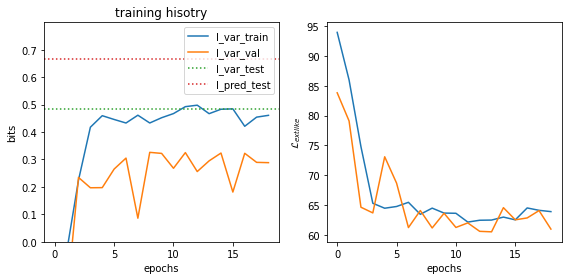

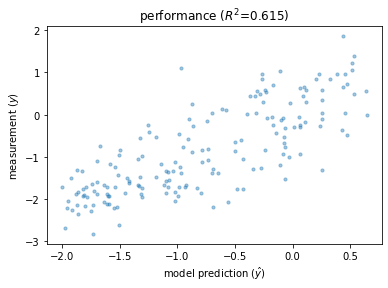

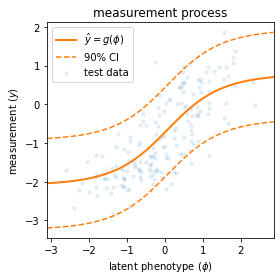

<ipython-input-5-c907409ffe14>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0204 sec.
Epoch 1/1000
9/9 [==============================] - 0s 17ms/step - loss: 93.5046 - I_var: -0.1354 - val_loss: 88.9271 - val_I_var: -0.1067
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 90.1952 - I_var: -0.1062 - val_loss: 86.4065 - val_I_var: -0.1041
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 86.5677 - I_var: -0.0491 - val_loss: 78.7193 - val_I_var: 0.1283
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 73.5504 - I_var: 0.2511 - val_loss: 69.1034 - val_I_var: 0.4107
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 69.1675 - I_var: 0.3560 - val_loss: 65.7619 - val_I_var: 0.5141
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 68.9550 - I_var: 0.3674 - val_loss: 66.7390 - val_I_var: 0.4979
Epoch 7/1000
9/9 [==============================] - 0s 3ms/ste

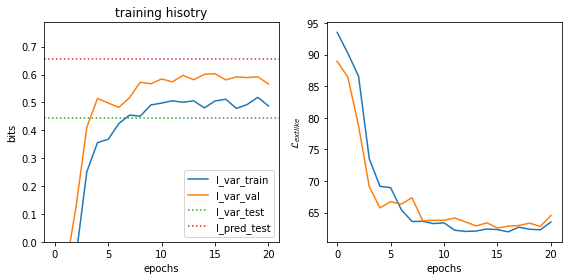

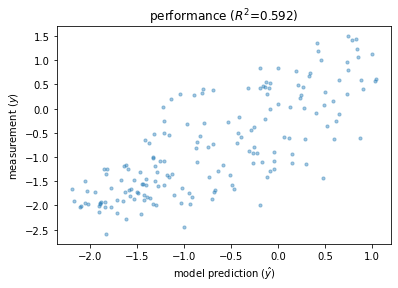

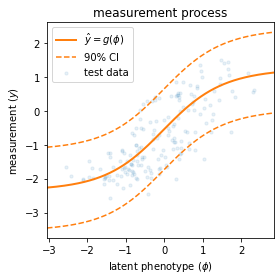

<ipython-input-5-c907409ffe14>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0205 sec.
Epoch 1/1000
9/9 [==============================] - 0s 16ms/step - loss: 89.0158 - I_var: -0.0201 - val_loss: 72.2804 - val_I_var: 0.2680
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 71.6169 - I_var: 0.3188 - val_loss: 61.8712 - val_I_var: 0.4840
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 65.0910 - I_var: 0.4577 - val_loss: 61.9472 - val_I_var: 0.5083
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 64.0671 - I_var: 0.4684 - val_loss: 63.3052 - val_I_var: 0.4036
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 65.3189 - I_var: 0.4293 - val_loss: 62.5273 - val_I_var: 0.4103
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 64.9716 - I_var: 0.4397 - val_loss: 62.1916 - val_I_var: 0.3956
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step - 

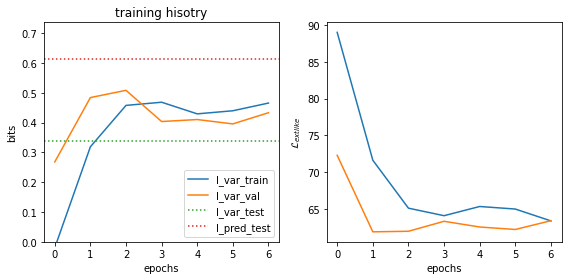

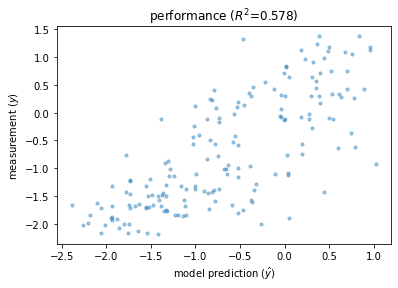

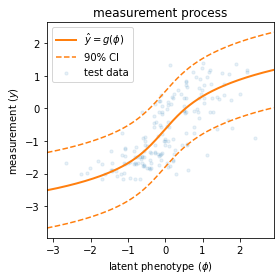

<ipython-input-5-c907409ffe14>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0181 sec.
Epoch 1/1000
9/9 [==============================] - 0s 18ms/step - loss: 89.5413 - I_var: -0.1016 - val_loss: 75.8679 - val_I_var: 0.1696
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 69.6922 - I_var: 0.2735 - val_loss: 63.3846 - val_I_var: 0.4013
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 66.3528 - I_var: 0.3399 - val_loss: 59.7325 - val_I_var: 0.5123
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 63.1493 - I_var: 0.4181 - val_loss: 59.3140 - val_I_var: 0.4914
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 64.4658 - I_var: 0.3897 - val_loss: 64.9285 - val_I_var: 0.4343
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 62.2582 - I_var: 0.4392 - val_loss: 60.5168 - val_I_var: 0.5277
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step - 

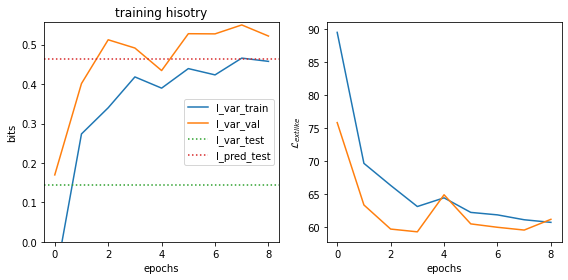

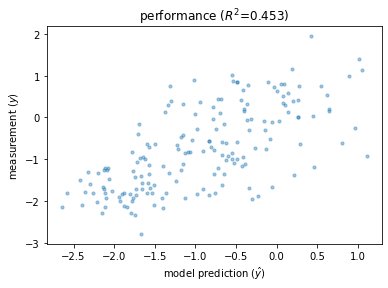

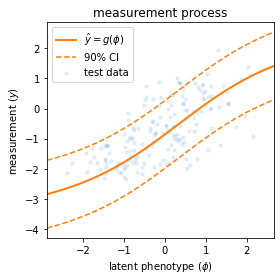

<ipython-input-5-c907409ffe14>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0191 sec.
Epoch 1/1000
9/9 [==============================] - 0s 16ms/step - loss: 94.6818 - I_var: -0.2007 - val_loss: 91.8302 - val_I_var: -0.3045
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 86.7843 - I_var: -0.1114 - val_loss: 75.4712 - val_I_var: 0.0446
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 73.7334 - I_var: 0.2156 - val_loss: 65.2559 - val_I_var: 0.2722
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 69.1737 - I_var: 0.3100 - val_loss: 61.5052 - val_I_var: 0.3527
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 65.8973 - I_var: 0.3632 - val_loss: 60.0690 - val_I_var: 0.4468
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 65.6491 - I_var: 0.3792 - val_loss: 59.3896 - val_I_var: 0.4245
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step 

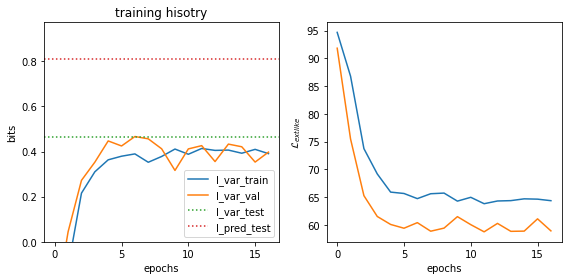

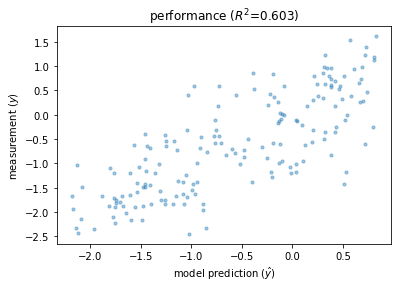

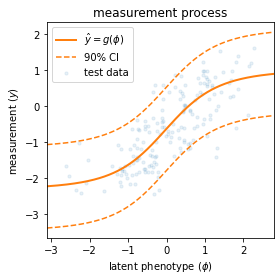

<ipython-input-5-c907409ffe14>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0198 sec.
Epoch 1/1000
9/9 [==============================] - 0s 16ms/step - loss: 90.1319 - I_var: -0.1245 - val_loss: 80.4307 - val_I_var: -0.1213
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 74.2100 - I_var: 0.1788 - val_loss: 74.2870 - val_I_var: -0.0118
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 66.5694 - I_var: 0.3488 - val_loss: 68.6738 - val_I_var: 0.1561
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 64.3616 - I_var: 0.3714 - val_loss: 65.3784 - val_I_var: 0.2626
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 63.8384 - I_var: 0.3786 - val_loss: 66.0545 - val_I_var: 0.2481
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 64.0012 - I_var: 0.3747 - val_loss: 62.8126 - val_I_var: 0.3373
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step 

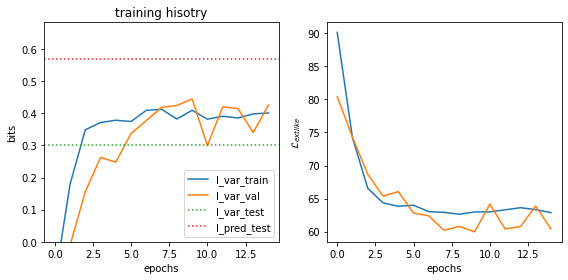

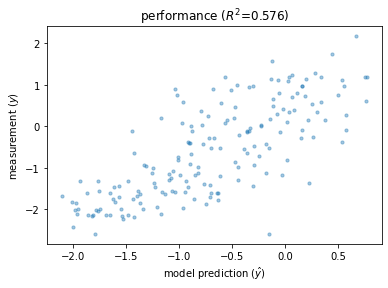

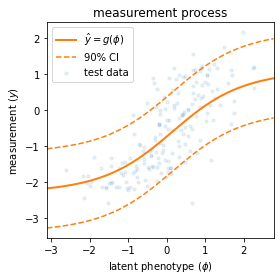

<ipython-input-5-c907409ffe14>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0178 sec.
Epoch 1/1000
9/9 [==============================] - 0s 18ms/step - loss: 98.2489 - I_var: -0.2086 - val_loss: 87.8773 - val_I_var: -0.2025
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 83.1032 - I_var: 0.0201 - val_loss: 69.9864 - val_I_var: 0.1970
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 69.0863 - I_var: 0.3269 - val_loss: 59.7691 - val_I_var: 0.4761
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 66.0491 - I_var: 0.3709 - val_loss: 61.4118 - val_I_var: 0.4396
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 65.1384 - I_var: 0.3952 - val_loss: 62.7825 - val_I_var: 0.4358
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 66.8584 - I_var: 0.3729 - val_loss: 59.9211 - val_I_var: 0.4122
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step -

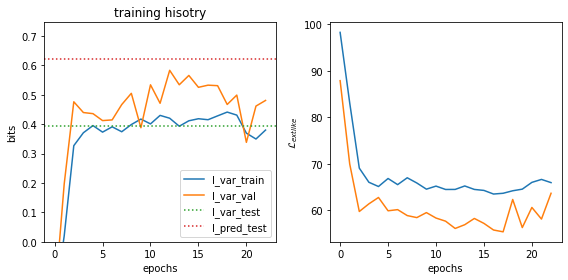

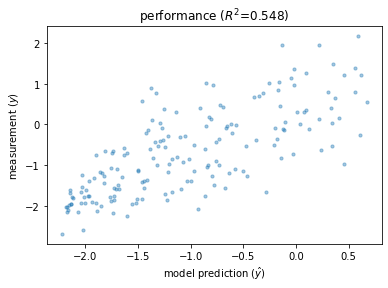

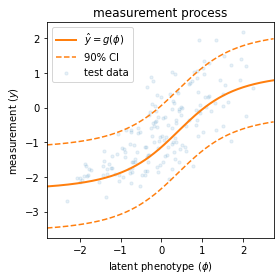

<ipython-input-5-c907409ffe14>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0191 sec.
Epoch 1/1000
9/9 [==============================] - 0s 18ms/step - loss: 86.5917 - I_var: 0.0219 - val_loss: 68.8834 - val_I_var: 0.3272
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 66.9180 - I_var: 0.3876 - val_loss: 65.1287 - val_I_var: 0.4811
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 64.9938 - I_var: 0.4190 - val_loss: 62.3098 - val_I_var: 0.5105
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 64.5791 - I_var: 0.4070 - val_loss: 65.2837 - val_I_var: 0.3901
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 65.6063 - I_var: 0.4088 - val_loss: 72.9276 - val_I_var: 0.2315
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 67.4359 - I_var: 0.3672 - val_loss: 62.9421 - val_I_var: 0.4892
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step - l

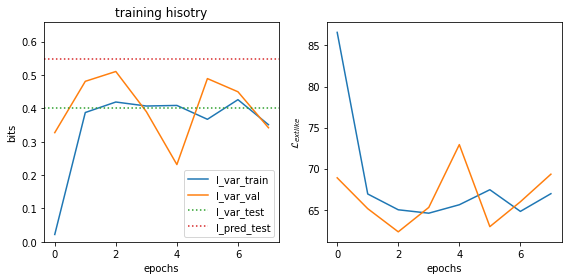

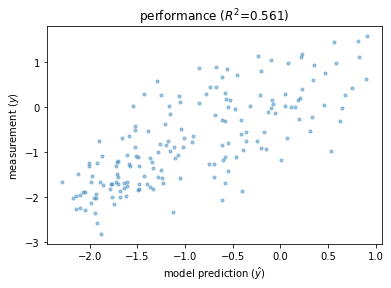

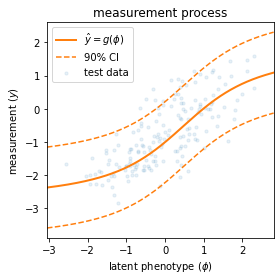

<ipython-input-5-c907409ffe14>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0173 sec.
Epoch 1/1000
9/9 [==============================] - 0s 16ms/step - loss: 100.0076 - I_var: -0.1726 - val_loss: 89.1301 - val_I_var: -0.1630
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 90.1512 - I_var: -0.1167 - val_loss: 86.8118 - val_I_var: -0.1579
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 88.7114 - I_var: -0.1059 - val_loss: 85.4282 - val_I_var: -0.1303
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 83.2035 - I_var: 0.0505 - val_loss: 66.1715 - val_I_var: 0.2939
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 70.0841 - I_var: 0.3636 - val_loss: 65.7522 - val_I_var: 0.2438
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 68.1119 - I_var: 0.3805 - val_loss: 57.0086 - val_I_var: 0.4710
Epoch 7/1000
9/9 [==============================] - 0s 3ms/s

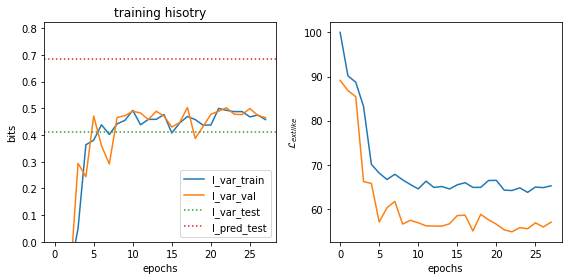

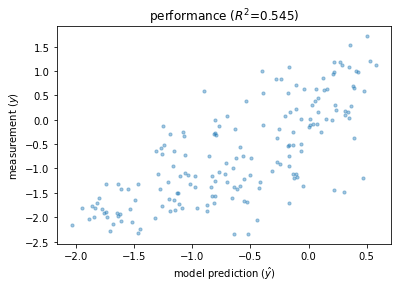

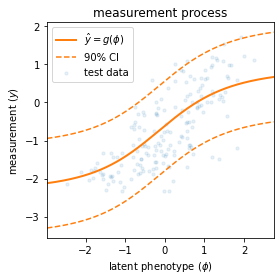

<ipython-input-5-c907409ffe14>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0175 sec.
Epoch 1/1000
9/9 [==============================] - 0s 16ms/step - loss: 95.9451 - I_var: -0.1149 - val_loss: 88.3960 - val_I_var: -0.1197
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 76.6777 - I_var: 0.1968 - val_loss: 68.0575 - val_I_var: 0.4073
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 67.9892 - I_var: 0.3537 - val_loss: 61.0089 - val_I_var: 0.5878
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 66.8530 - I_var: 0.3605 - val_loss: 63.9111 - val_I_var: 0.4944
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 66.2928 - I_var: 0.3870 - val_loss: 62.4345 - val_I_var: 0.5290
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 65.1477 - I_var: 0.4166 - val_loss: 61.5483 - val_I_var: 0.5619
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step -

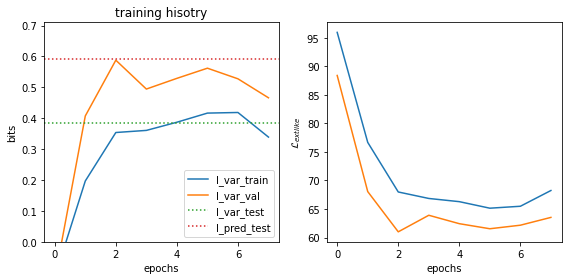

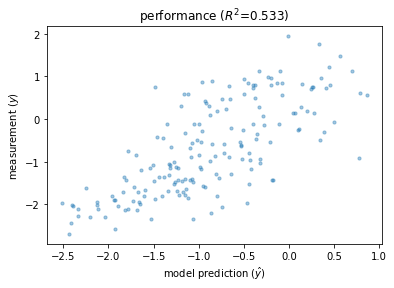

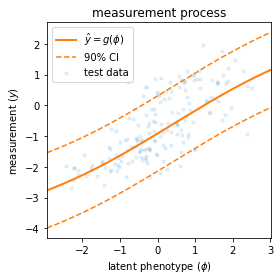

<ipython-input-5-c907409ffe14>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0174 sec.
Epoch 1/1000
9/9 [==============================] - 0s 16ms/step - loss: 96.3695 - I_var: -0.0266 - val_loss: 83.5968 - val_I_var: -0.0203
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 73.5035 - I_var: 0.3129 - val_loss: 78.9813 - val_I_var: 0.0183
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 69.9548 - I_var: 0.3748 - val_loss: 80.7219 - val_I_var: 0.0431
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 68.2796 - I_var: 0.4098 - val_loss: 71.4059 - val_I_var: 0.2518
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 65.6133 - I_var: 0.4466 - val_loss: 81.8194 - val_I_var: 0.1500
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 67.7355 - I_var: 0.4139 - val_loss: 71.7948 - val_I_var: 0.1884
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step -

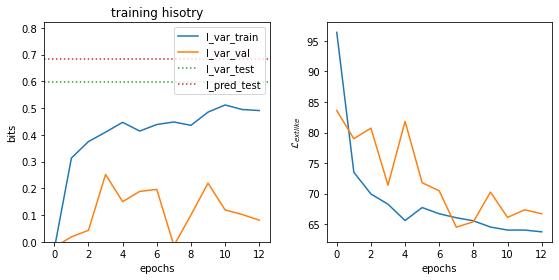

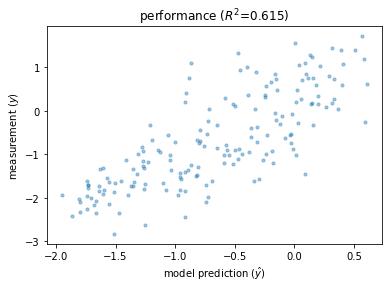

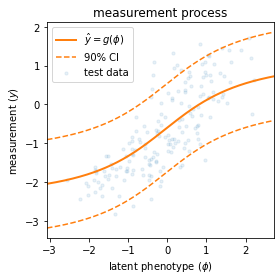

<ipython-input-5-c907409ffe14>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0172 sec.
Epoch 1/1000
9/9 [==============================] - 0s 16ms/step - loss: 103.1640 - I_var: -0.1507 - val_loss: 87.3779 - val_I_var: -0.0102
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 82.4490 - I_var: 0.0783 - val_loss: 62.5398 - val_I_var: 0.4797
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 69.3702 - I_var: 0.3492 - val_loss: 56.7047 - val_I_var: 0.6692
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 66.6708 - I_var: 0.4059 - val_loss: 60.7512 - val_I_var: 0.5609
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 66.6966 - I_var: 0.4083 - val_loss: 59.8657 - val_I_var: 0.5797
Epoch 6/1000
9/9 [==============================] - 0s 4ms/step - loss: 67.6097 - I_var: 0.3974 - val_loss: 60.6830 - val_I_var: 0.5634
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step 

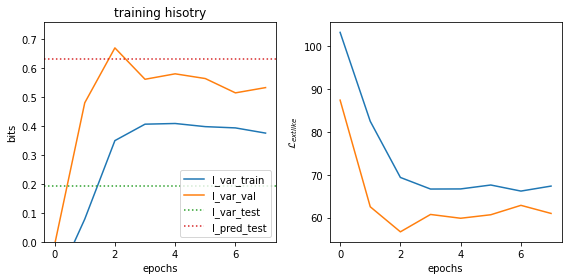

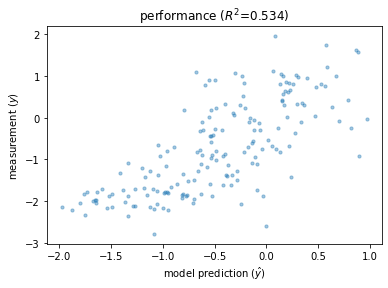

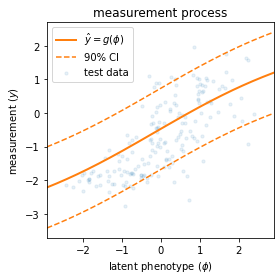

<ipython-input-5-c907409ffe14>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0175 sec.
Epoch 1/1000
9/9 [==============================] - 0s 16ms/step - loss: 104.1527 - I_var: -0.1201 - val_loss: 82.1647 - val_I_var: 0.0969
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 76.5965 - I_var: 0.2334 - val_loss: 68.7025 - val_I_var: 0.3488
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 69.1636 - I_var: 0.3756 - val_loss: 68.0188 - val_I_var: 0.2834
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 66.0739 - I_var: 0.4249 - val_loss: 69.7185 - val_I_var: 0.1989
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 66.5294 - I_var: 0.3970 - val_loss: 65.9989 - val_I_var: 0.3510
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 65.1703 - I_var: 0.4298 - val_loss: 65.3034 - val_I_var: 0.3973
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step -

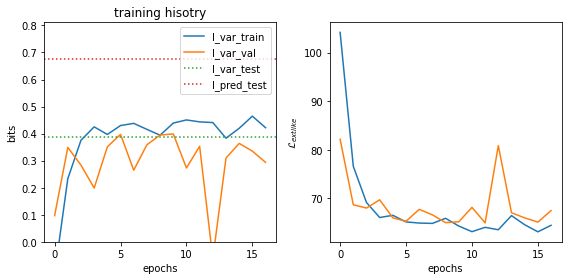

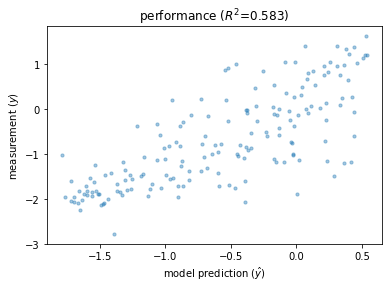

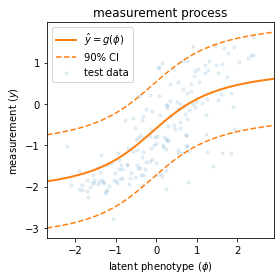

<ipython-input-5-c907409ffe14>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0192 sec.
Epoch 1/1000
9/9 [==============================] - 0s 16ms/step - loss: 105.8938 - I_var: -0.1563 - val_loss: 88.2357 - val_I_var: -0.0214
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 79.1561 - I_var: 0.1911 - val_loss: 68.7314 - val_I_var: 0.2912
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 66.0329 - I_var: 0.4379 - val_loss: 67.4218 - val_I_var: 0.3554
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 65.5732 - I_var: 0.4535 - val_loss: 68.2907 - val_I_var: 0.3704
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 64.0370 - I_var: 0.4762 - val_loss: 65.8752 - val_I_var: 0.3899
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 64.3688 - I_var: 0.4658 - val_loss: 70.0754 - val_I_var: 0.1877
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step 

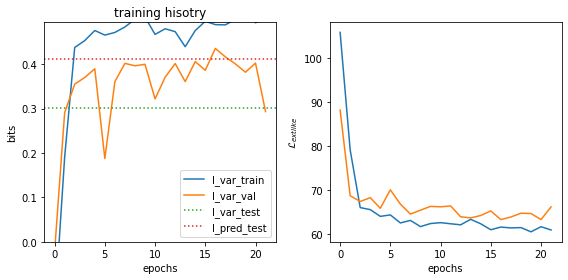

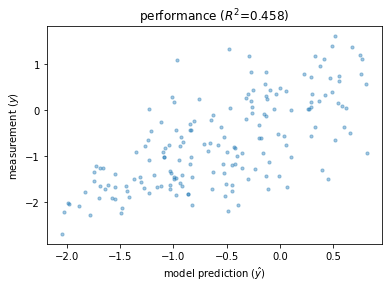

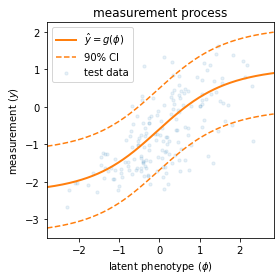

<ipython-input-5-c907409ffe14>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0177 sec.
Epoch 1/1000
9/9 [==============================] - 0s 16ms/step - loss: 106.4853 - I_var: -0.1319 - val_loss: 84.7709 - val_I_var: 0.0750
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 77.8401 - I_var: 0.2077 - val_loss: 66.6548 - val_I_var: 0.4555
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 68.5633 - I_var: 0.3410 - val_loss: 67.9537 - val_I_var: 0.4275
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 66.8927 - I_var: 0.3964 - val_loss: 71.1390 - val_I_var: 0.3200
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 67.9616 - I_var: 0.3602 - val_loss: 66.0085 - val_I_var: 0.4387
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 65.5632 - I_var: 0.3882 - val_loss: 70.7756 - val_I_var: 0.3141
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step -

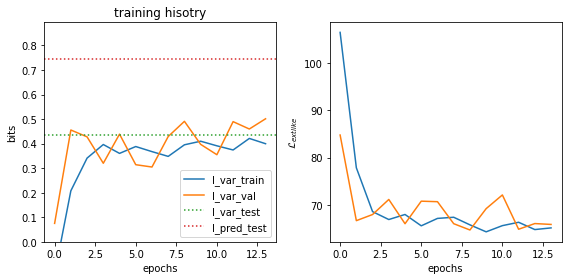

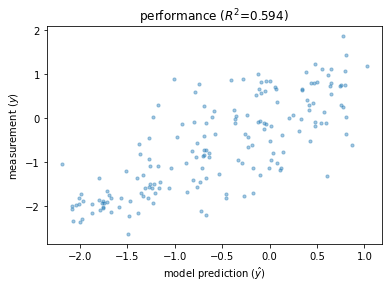

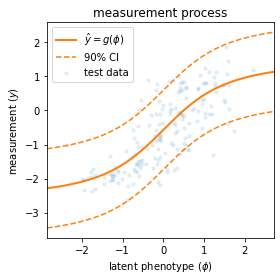

<ipython-input-5-c907409ffe14>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0175 sec.
Epoch 1/1000
9/9 [==============================] - 0s 16ms/step - loss: 110.4272 - I_var: -0.2387 - val_loss: 93.8999 - val_I_var: -0.2468
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 90.8277 - I_var: -0.1230 - val_loss: 91.7299 - val_I_var: -0.3583
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 88.9305 - I_var: -0.1184 - val_loss: 90.4093 - val_I_var: -0.3378
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 87.9201 - I_var: -0.1189 - val_loss: 88.6323 - val_I_var: -0.2809
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 87.5073 - I_var: -0.1162 - val_loss: 89.1697 - val_I_var: -0.3120
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 87.6133 - I_var: -0.1105 - val_loss: 89.2917 - val_I_var: -0.3236
Epoch 7/1000
9/9 [==============================] - 0s

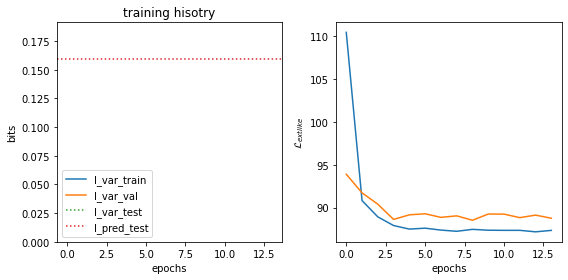

/Users/yiquan/opt/anaconda3/envs/NA/lib/python3.8/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yiquan/opt/anaconda3/envs/NA/lib/python3.8/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


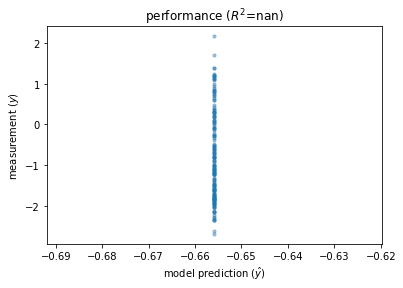

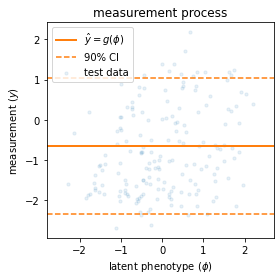

<ipython-input-5-c907409ffe14>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0176 sec.
Epoch 1/1000
9/9 [==============================] - 0s 17ms/step - loss: 112.2918 - I_var: -0.1272 - val_loss: 97.1416 - val_I_var: -0.0893
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 85.9199 - I_var: 0.0473 - val_loss: 76.0865 - val_I_var: 0.1799
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 72.8888 - I_var: 0.3264 - val_loss: 67.8788 - val_I_var: 0.2120
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 72.9154 - I_var: 0.3273 - val_loss: 67.5612 - val_I_var: 0.4563
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 71.6076 - I_var: 0.3401 - val_loss: 66.9944 - val_I_var: 0.3085
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 69.0584 - I_var: 0.4018 - val_loss: 65.5782 - val_I_var: 0.4418
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step 

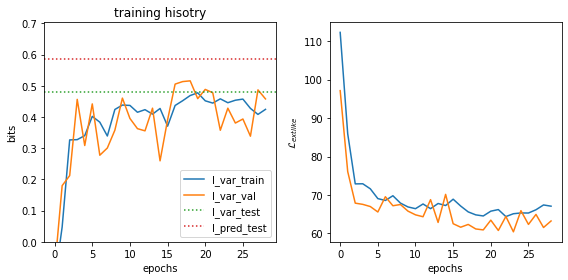

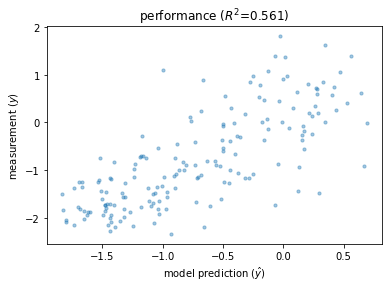

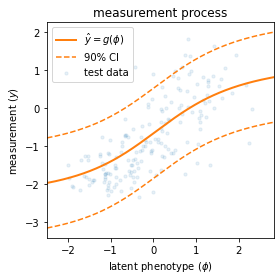

<ipython-input-5-c907409ffe14>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0174 sec.
Epoch 1/1000
9/9 [==============================] - 0s 17ms/step - loss: 122.4612 - I_var: -0.2989 - val_loss: 94.6537 - val_I_var: -0.1748
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 95.6059 - I_var: -0.2086 - val_loss: 86.3562 - val_I_var: -0.1707
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 91.2294 - I_var: -0.1859 - val_loss: 85.4082 - val_I_var: -0.1883
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 90.0383 - I_var: -0.1967 - val_loss: 84.1874 - val_I_var: -0.1803
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 89.0559 - I_var: -0.1909 - val_loss: 83.8910 - val_I_var: -0.1764
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 88.1562 - I_var: -0.1595 - val_loss: 80.9057 - val_I_var: -0.0935
Epoch 7/1000
9/9 [==============================] - 0s

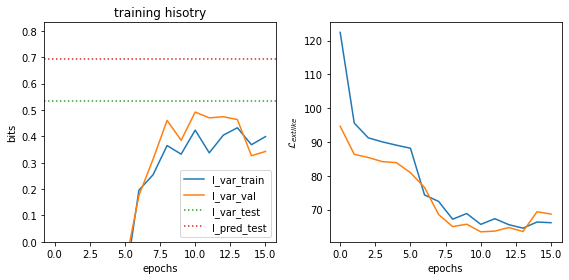

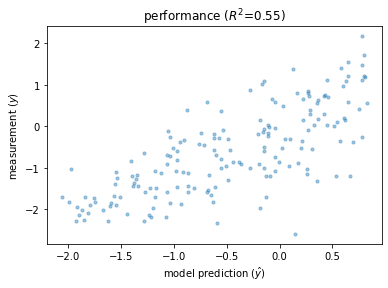

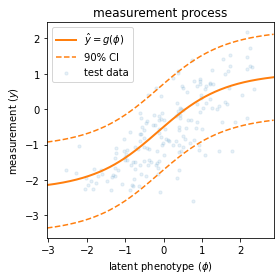

<ipython-input-5-c907409ffe14>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.02 sec.
Epoch 1/1000
9/9 [==============================] - 0s 16ms/step - loss: 175.9906 - I_var: -0.2094 - val_loss: 107.0111 - val_I_var: -0.1663
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 100.6841 - I_var: -0.1624 - val_loss: 95.2180 - val_I_var: -0.1705
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 94.6057 - I_var: -0.1602 - val_loss: 90.0279 - val_I_var: -0.1572
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 90.8553 - I_var: -0.1637 - val_loss: 88.2024 - val_I_var: -0.1689
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 89.3842 - I_var: -0.1570 - val_loss: 87.3180 - val_I_var: -0.1583
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 88.6170 - I_var: -0.1596 - val_loss: 86.9644 - val_I_var: -0.1595
Epoch 7/1000
9/9 [==============================] - 0s

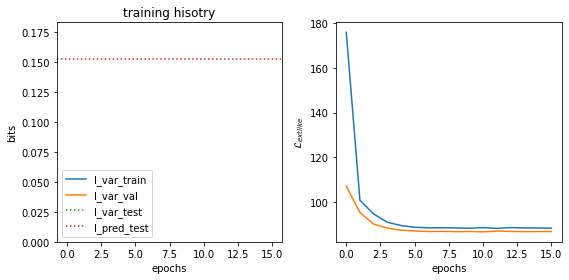

/Users/yiquan/opt/anaconda3/envs/NA/lib/python3.8/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yiquan/opt/anaconda3/envs/NA/lib/python3.8/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


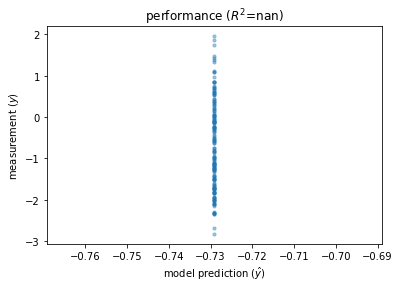

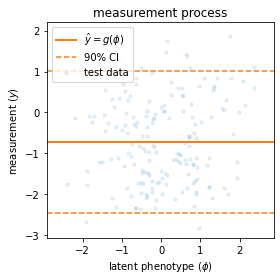

<ipython-input-5-c907409ffe14>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0175 sec.
Epoch 1/1000
9/9 [==============================] - 0s 16ms/step - loss: 194.9093 - I_var: -0.1736 - val_loss: 117.0834 - val_I_var: -0.1159
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 106.6459 - I_var: -0.1461 - val_loss: 94.1568 - val_I_var: -0.1029
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 94.7635 - I_var: -0.1346 - val_loss: 88.8431 - val_I_var: -0.1029
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 91.4823 - I_var: -0.1257 - val_loss: 87.4431 - val_I_var: -0.1019
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 89.8305 - I_var: -0.1425 - val_loss: 86.3505 - val_I_var: -0.1091
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 89.1559 - I_var: -0.1335 - val_loss: 85.7653 - val_I_var: -0.1087
Epoch 7/1000
9/9 [==============================] - 

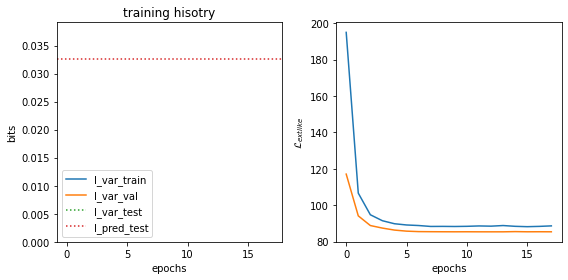

/Users/yiquan/opt/anaconda3/envs/NA/lib/python3.8/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yiquan/opt/anaconda3/envs/NA/lib/python3.8/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


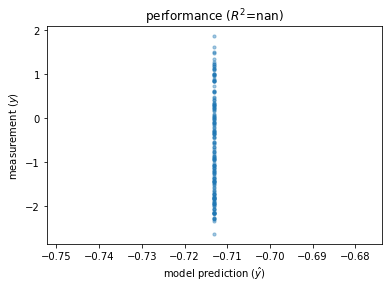

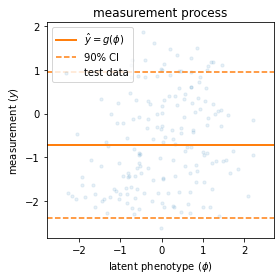

[[0.89509587]
 [0.75610159]
 [0.89986846]
 [0.95152473]
 [0.8858326 ]
 [0.97199585]
 [0.98102543]
 [0.22097272]
 [0.98442326]
 [0.15320841]]
[[0.61496721 0.5919311 ]
 [0.57849576 0.45321717]
 [0.60286234 0.57562706]
 [0.54768917 0.56132768]
 [0.54463913 0.53342604]
 [0.6148082  0.5341562 ]
 [0.58315576 0.45788616]
 [0.59398702        nan]
 [0.56085314 0.55020823]
 [       nan        nan]]


In [16]:
#Find the best regularization for additive fitness(regularization)
reg_ls=[1e-2,5e-2,1e-1,3e-1,5e-1,8e-1,1,1.5,2,10]
add=np.zeros((10,1))
epi=np.zeros((10,1))
R_sq=np.zeros((10,2))
R2=np.zeros((19,2))

for reg in reg_ls:
    for rep in [0,1]:
        train_set, test_set = LoadData('../result/NA_compile_results.tsv','HK19')
        model = Train_model(train_set,test_set,reg,0.05,64)
        PlotTrain(model,test_set)
        Rsq=PlotR2(model,test_set)
        PlotGEnonlinearity(model,test_set)
        theta = model.get_theta()
#         fig, ax = plt.subplots(1, 1, figsize=[16, 10])
#         mavenn.heatmap_pairwise(values=theta['theta_lclc'],alphabet=theta['alphabet'], ax=ax);
        theta_lc=theta['theta_lc']
#         data = theta['theta_lclc']
#         epi_map=array2df(data)
#         epi_map=epi_map.dropna(thresh=3)
#         epi_df = df2epimap(epi_map)

        add_df=reformat(theta_lc)
        R2[:,rep]=add_df['add_fit']
        index=reg_ls.index(reg)
        R_sq[index,rep]=Rsq
#         R2_epi[:,rep]=epi_df['EPI']
    R = np.corrcoef(R2[:,0], R2[:,1])[0, 1]
#     R_epi = np.corrcoef(R2_epi[:,0], R2_epi[:,1])[0, 1]
    index = reg_ls.index(reg)
    add[index,0]=R
#     epi[index,0]=R_epi
HK19_Rsq=R_sq
print(add)
print(R_sq)
# print(epi)


In [19]:
HK68_Rsq_df=pd.DataFrame(HK68_Rsq)
Bk79_Rsq_df=pd.DataFrame(Bk79_Rsq)
Bei89_Rsq_df=pd.DataFrame(Bei89_Rsq)
Mos99_Rsq_df=pd.DataFrame(Mos99_Rsq)
Vic11_Rsq_df=pd.DataFrame(Vic11_Rsq)
HK19_Rsq_df=pd.DataFrame(HK19_Rsq)
Rsq_df=pd.concat([HK68_Rsq_df,Bk79_Rsq_df,Bei89_Rsq_df,Mos99_Rsq_df,Vic11_Rsq_df,HK19_Rsq_df])
print(Rsq_df)
Rsq_df.to_csv('../result/add_only_model_reg_R2.csv')

          0         1
0  0.297027  0.394502
1  0.379294  0.314918
2  0.356046  0.378675
3  0.287463  0.298373
4  0.386643  0.312337
5  0.238233  0.242390
6  0.305909  0.247627
7  0.319108  0.432583
8       NaN       NaN
9       NaN       NaN
0  0.414479  0.520468
1  0.510883  0.478352
2  0.491522  0.535856
3  0.451726  0.496578
4  0.555563       NaN
5  0.447902  0.550689
6  0.490109  0.507607
7  0.527525  0.464251
8  0.466285       NaN
9  0.506229       NaN
0  0.776183  0.760931
1  0.795961  0.708297
2  0.747011  0.755466
3  0.753418  0.769738
4  0.844753  0.754271
5  0.709106  0.735425
6  0.801452  0.724119
7  0.777026  0.739592
8  0.754751  0.753859
9       NaN       NaN
0  0.694907  0.730515
1  0.639217  0.661823
2  0.378985  0.710380
3  0.614995  0.675480
4  0.746338  0.600579
5  0.681417  0.724749
6  0.705142  0.567169
7  0.743652  0.649816
8       NaN  0.693184
9  0.566661       NaN
0  0.597658  0.646948
1  0.618522  0.617488
2  0.665690  0.634781
3  0.598591  0.688667
4  0.67656

<ipython-input-2-10e8bdd99990>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0206 sec.
Epoch 1/1000
9/9 [==============================] - 0s 17ms/step - loss: 113.3672 - I_var: -0.2477 - val_loss: 108.8945 - val_I_var: -0.2578
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 108.9015 - I_var: -0.1568 - val_loss: 106.0800 - val_I_var: -0.1861
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 106.9845 - I_var: -0.1305 - val_loss: 104.7312 - val_I_var: -0.1572
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 105.8946 - I_var: -0.1273 - val_loss: 103.8674 - val_I_var: -0.1435
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 105.2636 - I_var: -0.1239 - val_loss: 103.2074 - val_I_var: -0.1365
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 104.7992 - I_var: -0.1161 - val_loss: 102.6429 - val_I_var: -0.1343
Epoch 7/1000
9/9 [=========================

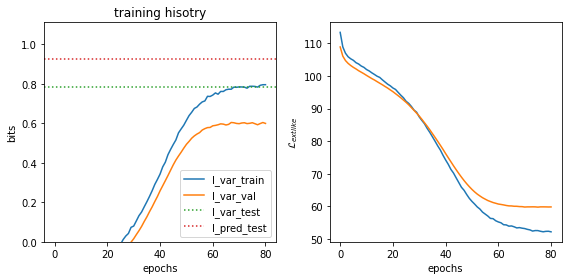

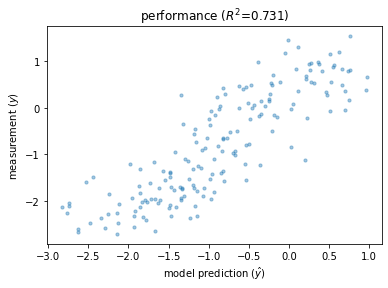

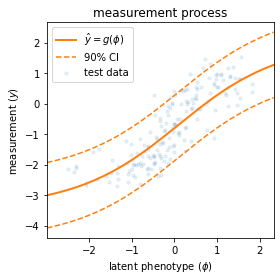

<ipython-input-2-10e8bdd99990>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0192 sec.
Epoch 1/1000
9/9 [==============================] - 0s 17ms/step - loss: 128.9390 - I_var: -0.6531 - val_loss: 121.8962 - val_I_var: -0.5348
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 118.9057 - I_var: -0.4179 - val_loss: 113.2729 - val_I_var: -0.3429
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 113.2417 - I_var: -0.3043 - val_loss: 109.0662 - val_I_var: -0.2567
Epoch 4/1000
9/9 [==============================] - 0s 2ms/step - loss: 110.3435 - I_var: -0.2571 - val_loss: 106.5233 - val_I_var: -0.2096
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 108.9301 - I_var: -0.2203 - val_loss: 104.7873 - val_I_var: -0.1813
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 107.3544 - I_var: -0.2106 - val_loss: 103.4619 - val_I_var: -0.1620
Epoch 7/1000
9/9 [=========================

Epoch 59/1000
9/9 [==============================] - 0s 3ms/step - loss: 92.3889 - I_var: -0.1735 - val_loss: 89.3812 - val_I_var: -0.1369
Epoch 60/1000
9/9 [==============================] - 0s 3ms/step - loss: 92.0962 - I_var: -0.1798 - val_loss: 89.2812 - val_I_var: -0.1369
Epoch 61/1000
9/9 [==============================] - 0s 3ms/step - loss: 92.1605 - I_var: -0.1741 - val_loss: 89.1877 - val_I_var: -0.1371
Epoch 62/1000
9/9 [==============================] - 0s 3ms/step - loss: 91.8330 - I_var: -0.1819 - val_loss: 89.0752 - val_I_var: -0.1368
Epoch 63/1000
9/9 [==============================] - 0s 3ms/step - loss: 91.8153 - I_var: -0.1791 - val_loss: 88.9902 - val_I_var: -0.1370
Epoch 64/1000
9/9 [==============================] - 0s 3ms/step - loss: 91.7062 - I_var: -0.1795 - val_loss: 88.8948 - val_I_var: -0.1370
Epoch 65/1000
9/9 [==============================] - 0s 3ms/step - loss: 91.7572 - I_var: -0.1747 - val_loss: 88.8043 - val_I_var: -0.1370
Epoch 66/1000
9/9 [========

Epoch 118/1000
9/9 [==============================] - 0s 3ms/step - loss: 89.2443 - I_var: -0.1727 - val_loss: 86.3028 - val_I_var: -0.1376
Epoch 119/1000
9/9 [==============================] - 0s 3ms/step - loss: 89.4089 - I_var: -0.1666 - val_loss: 86.2637 - val_I_var: -0.1373
Epoch 120/1000
9/9 [==============================] - 0s 3ms/step - loss: 89.2447 - I_var: -0.1713 - val_loss: 86.2484 - val_I_var: -0.1374
Epoch 121/1000
9/9 [==============================] - 0s 3ms/step - loss: 89.1415 - I_var: -0.1741 - val_loss: 86.2254 - val_I_var: -0.1373
Epoch 122/1000
9/9 [==============================] - 0s 3ms/step - loss: 88.9826 - I_var: -0.1788 - val_loss: 86.2126 - val_I_var: -0.1373
Epoch 123/1000
9/9 [==============================] - 0s 3ms/step - loss: 88.8202 - I_var: -0.1837 - val_loss: 86.2016 - val_I_var: -0.1374
Epoch 124/1000
9/9 [==============================] - 0s 3ms/step - loss: 88.8995 - I_var: -0.1804 - val_loss: 86.1870 - val_I_var: -0.1375
Epoch 125/1000
9/9 [

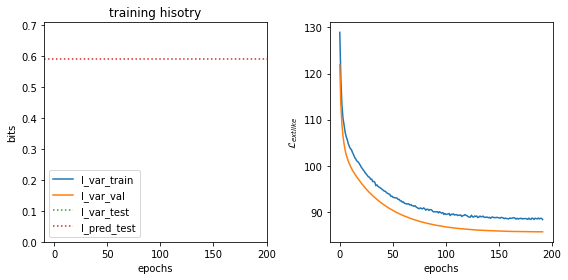

/Users/yiquan/opt/anaconda3/envs/NA/lib/python3.8/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yiquan/opt/anaconda3/envs/NA/lib/python3.8/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


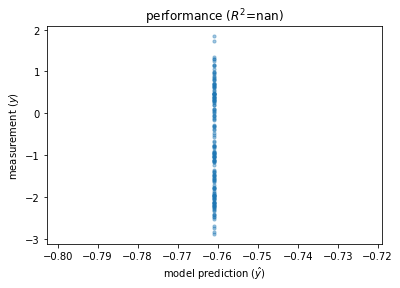

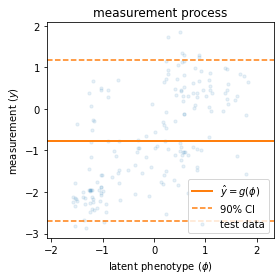

<ipython-input-2-10e8bdd99990>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0193 sec.
Epoch 1/1000
9/9 [==============================] - 0s 17ms/step - loss: 110.4017 - I_var: -0.3278 - val_loss: 96.7451 - val_I_var: -0.2269
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 100.9172 - I_var: -0.1645 - val_loss: 95.4412 - val_I_var: -0.2360
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 98.8034 - I_var: -0.1589 - val_loss: 93.8907 - val_I_var: -0.2404
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 96.9609 - I_var: -0.1652 - val_loss: 91.9992 - val_I_var: -0.2346
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 95.6661 - I_var: -0.1524 - val_loss: 89.5048 - val_I_var: -0.2131
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 94.1088 - I_var: -0.1440 - val_loss: 87.7652 - val_I_var: -0.1930
Epoch 7/1000
9/9 [==============================] - 0

Epoch 60/1000
9/9 [==============================] - 0s 3ms/step - loss: 45.4168 - I_var: 0.9195 - val_loss: 40.4360 - val_I_var: 0.9800
Epoch 61/1000
9/9 [==============================] - 0s 3ms/step - loss: 45.1011 - I_var: 0.9011 - val_loss: 40.4227 - val_I_var: 0.9822
Epoch 62/1000
9/9 [==============================] - 0s 3ms/step - loss: 44.8751 - I_var: 0.9146 - val_loss: 40.5031 - val_I_var: 0.9747
Epoch 63/1000
9/9 [==============================] - 0s 2ms/step - loss: 44.8452 - I_var: 0.9130 - val_loss: 40.3564 - val_I_var: 0.9843
Epoch 64/1000
9/9 [==============================] - 0s 3ms/step - loss: 45.0398 - I_var: 0.9209 - val_loss: 40.1659 - val_I_var: 0.9810
Epoch 65/1000
9/9 [==============================] - 0s 3ms/step - loss: 44.5718 - I_var: 0.9151 - val_loss: 40.0312 - val_I_var: 0.9867
Epoch 66/1000
9/9 [==============================] - 0s 3ms/step - loss: 44.8515 - I_var: 0.9240 - val_loss: 40.1510 - val_I_var: 0.9840
Epoch 67/1000
9/9 [======================

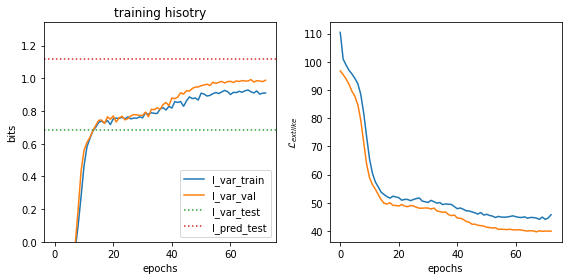

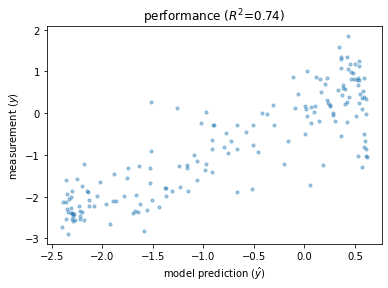

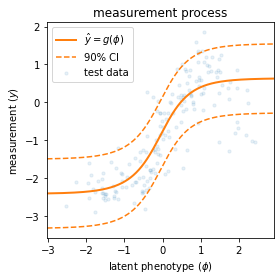

<ipython-input-2-10e8bdd99990>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0175 sec.
Epoch 1/1000
9/9 [==============================] - 0s 16ms/step - loss: 107.7859 - I_var: -0.1900 - val_loss: 98.7582 - val_I_var: -0.1853
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 103.3559 - I_var: -0.1639 - val_loss: 93.6001 - val_I_var: -0.1431
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 99.5186 - I_var: -0.1279 - val_loss: 89.7423 - val_I_var: -0.0888
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 95.6337 - I_var: -0.0867 - val_loss: 85.5967 - val_I_var: -0.0223
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 91.4640 - I_var: -0.0338 - val_loss: 80.9666 - val_I_var: 0.0652
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 86.6234 - I_var: 0.0519 - val_loss: 75.9341 - val_I_var: 0.1783
Epoch 7/1000
9/9 [==============================] - 0s 3

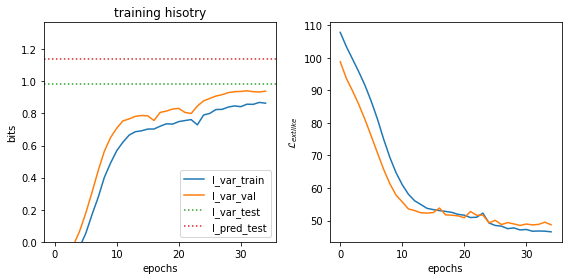

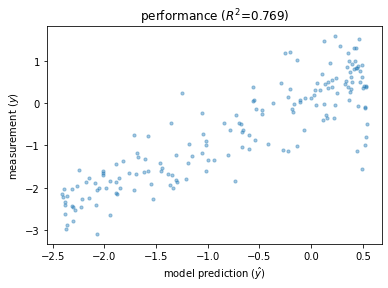

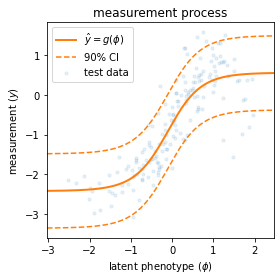

<ipython-input-2-10e8bdd99990>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0192 sec.
Epoch 1/1000
9/9 [==============================] - 0s 18ms/step - loss: 109.8464 - I_var: -0.2657 - val_loss: 106.8204 - val_I_var: -0.2469
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 101.3093 - I_var: -0.1695 - val_loss: 102.8898 - val_I_var: -0.2460
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 97.2953 - I_var: -0.1674 - val_loss: 99.7101 - val_I_var: -0.2495
Epoch 4/1000
9/9 [==============================] - 0s 2ms/step - loss: 94.2314 - I_var: -0.1711 - val_loss: 97.5241 - val_I_var: -0.2556
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 92.2837 - I_var: -0.1674 - val_loss: 95.8783 - val_I_var: -0.2565
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 91.0040 - I_var: -0.1628 - val_loss: 94.5025 - val_I_var: -0.2555
Epoch 7/1000
9/9 [==============================] -

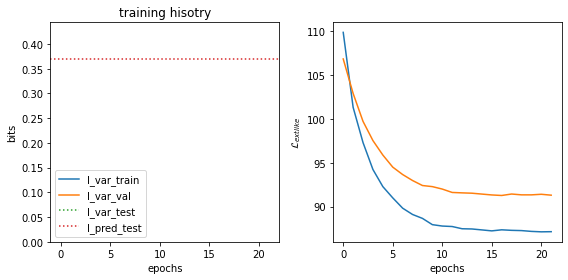

/Users/yiquan/opt/anaconda3/envs/NA/lib/python3.8/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yiquan/opt/anaconda3/envs/NA/lib/python3.8/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


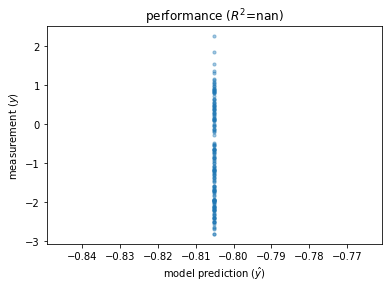

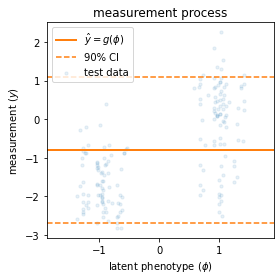

<ipython-input-2-10e8bdd99990>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0181 sec.
Epoch 1/1000
9/9 [==============================] - 0s 16ms/step - loss: 106.3418 - I_var: -0.1917 - val_loss: 94.0516 - val_I_var: -0.1414
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 98.4151 - I_var: -0.1105 - val_loss: 85.5301 - val_I_var: -0.0898
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 88.4407 - I_var: 0.0410 - val_loss: 74.2088 - val_I_var: 0.1203
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 76.8463 - I_var: 0.2705 - val_loss: 64.2083 - val_I_var: 0.3280
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 67.1531 - I_var: 0.4712 - val_loss: 57.1297 - val_I_var: 0.4713
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 60.0330 - I_var: 0.6047 - val_loss: 54.4811 - val_I_var: 0.4974
Epoch 7/1000
9/9 [==============================] - 0s 3ms/ste

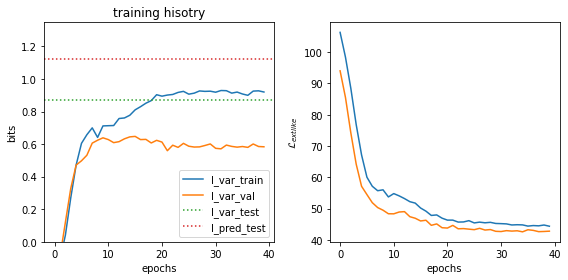

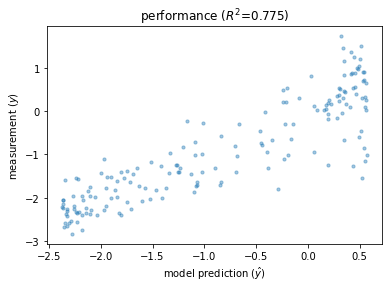

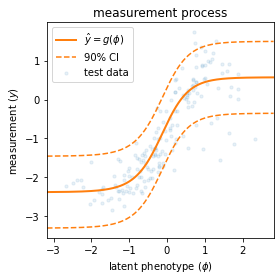

<ipython-input-2-10e8bdd99990>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0178 sec.
Epoch 1/1000
9/9 [==============================] - 0s 15ms/step - loss: 104.2617 - I_var: -0.1727 - val_loss: 88.4388 - val_I_var: -0.1387
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 81.7136 - I_var: 0.1620 - val_loss: 62.8174 - val_I_var: 0.3915
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 61.0187 - I_var: 0.5676 - val_loss: 54.4484 - val_I_var: 0.6052
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 57.7092 - I_var: 0.6057 - val_loss: 53.5316 - val_I_var: 0.5975
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 56.1668 - I_var: 0.6645 - val_loss: 60.2842 - val_I_var: 0.3743
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 56.5701 - I_var: 0.6713 - val_loss: 50.5350 - val_I_var: 0.6571
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step 

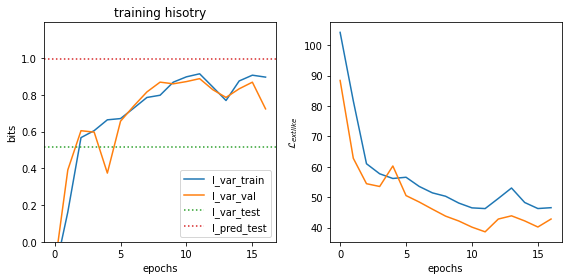

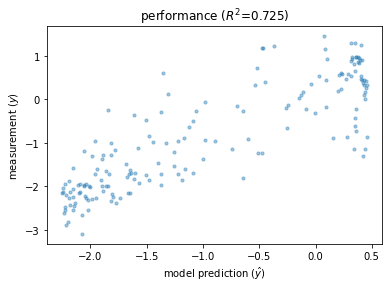

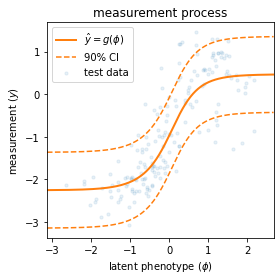

<ipython-input-2-10e8bdd99990>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0203 sec.
Epoch 1/1000
9/9 [==============================] - 0s 18ms/step - loss: 103.6623 - I_var: -0.1316 - val_loss: 89.5167 - val_I_var: -0.1812
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 80.5945 - I_var: 0.1987 - val_loss: 69.4936 - val_I_var: 0.3430
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 64.3308 - I_var: 0.4983 - val_loss: 60.9371 - val_I_var: 0.5847
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 58.1828 - I_var: 0.6274 - val_loss: 55.4599 - val_I_var: 0.7594
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 54.0612 - I_var: 0.7193 - val_loss: 55.5274 - val_I_var: 0.8149
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 52.6590 - I_var: 0.7611 - val_loss: 53.8209 - val_I_var: 0.7708
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step 

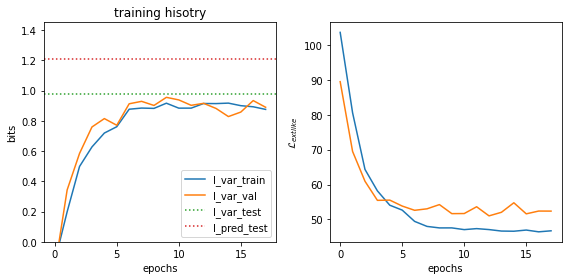

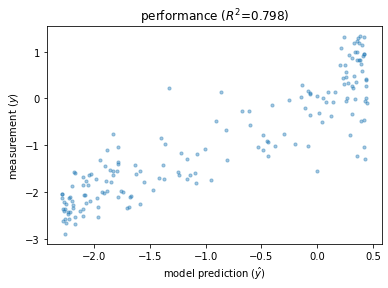

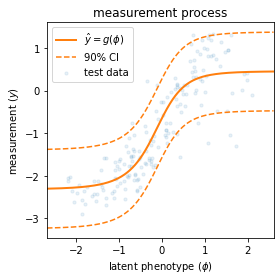

<ipython-input-2-10e8bdd99990>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.019 sec.
Epoch 1/1000
9/9 [==============================] - 0s 19ms/step - loss: 103.3079 - I_var: -0.1999 - val_loss: 83.0572 - val_I_var: -0.0355
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 76.1099 - I_var: 0.2140 - val_loss: 61.8959 - val_I_var: 0.3726
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 60.8574 - I_var: 0.4931 - val_loss: 64.9805 - val_I_var: 0.2032
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 59.7171 - I_var: 0.5383 - val_loss: 59.3007 - val_I_var: 0.3160
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 57.3031 - I_var: 0.5827 - val_loss: 56.7594 - val_I_var: 0.4387
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 57.0014 - I_var: 0.6013 - val_loss: 57.4920 - val_I_var: 0.4923
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step -

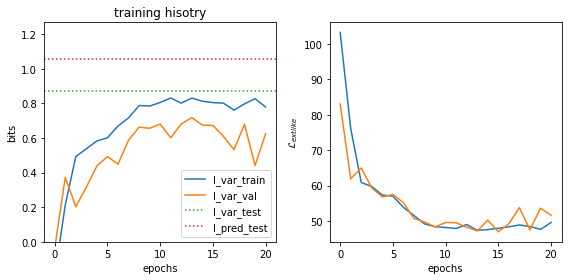

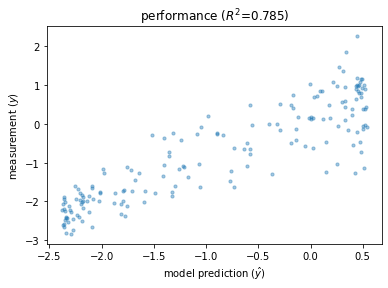

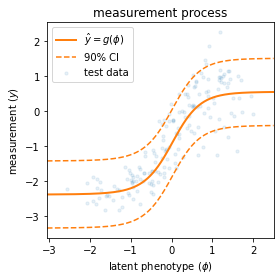

<ipython-input-2-10e8bdd99990>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0186 sec.
Epoch 1/1000
9/9 [==============================] - 0s 18ms/step - loss: 95.0954 - I_var: 0.0785 - val_loss: 75.5688 - val_I_var: 0.2241
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 61.0956 - I_var: 0.6032 - val_loss: 60.5585 - val_I_var: 0.1821
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 56.3754 - I_var: 0.7092 - val_loss: 61.2737 - val_I_var: 0.3881
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 55.8341 - I_var: 0.7100 - val_loss: 58.3368 - val_I_var: 0.4164
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 49.7203 - I_var: 0.8010 - val_loss: 57.6914 - val_I_var: 0.4068
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 48.4804 - I_var: 0.8564 - val_loss: 56.2809 - val_I_var: 0.3796
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step - l

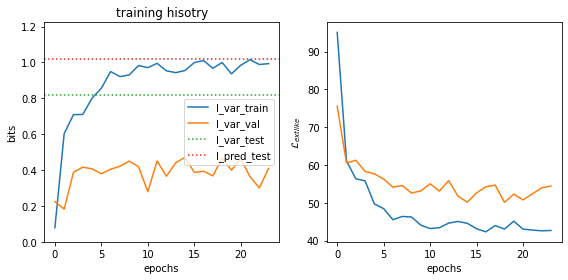

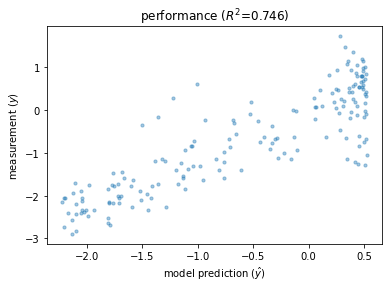

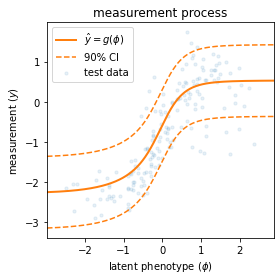

[[-0.44626413]
 [ 0.90442513]
 [-0.42461917]
 [ 0.9759818 ]
 [ 0.98896168]]


In [6]:
#Find the best regularization for additive fitness(learning rate)
lr_ls=[1e-3,5e-3,1e-2,3e-2,5e-2]
add=np.zeros((5,1))
epi=np.zeros((5,1))
R2=np.zeros((19,2))
R2_epi=np.zeros((153,2))
for lr in lr_ls:
    for rep in [0,1]:
        train_set, test_set = LoadData('../result/NA_compile_results.tsv','Bei89')
        model = Train_model(train_set,test_set,0.8,lr,64)
        PlotTrain(model,test_set)
        PlotR2(model,test_set)
        PlotGEnonlinearity(model,test_set)
        theta = model.get_theta()
#         fig, ax = plt.subplots(1, 1, figsize=[16, 10])
#         mavenn.heatmap_pairwise(values=theta['theta_lclc'],alphabet=theta['alphabet'], ax=ax);
        theta_lc=theta['theta_lc']
#         data = theta['theta_lclc']
#         epi_map=array2df(data)
#         epi_map=epi_map.dropna(thresh=3)
#         epi_df = df2epimap(epi_map)

        add_df=reformat(theta_lc)
        R2[:,rep]=add_df['add_fit']
#         R2_epi[:,rep]=epi_df['EPI']
    R = np.corrcoef(R2[:,0], R2[:,1])[0, 1]
#     R_epi = np.corrcoef(R2_epi[:,0], R2_epi[:,1])[0, 1]
    index = lr_ls.index(lr)
    add[index,0]=R
#     epi[index,0]=R_epi
print(add)
# print(epi)

<ipython-input-2-10e8bdd99990>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.019 sec.
Epoch 1/1000
35/35 [==============================] - 0s 5ms/step - loss: 25.3738 - I_var: 0.0029 - val_loss: 19.4982 - val_I_var: 0.2285
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 19.4250 - I_var: 0.2931 - val_loss: 19.8078 - val_I_var: 0.2512
Epoch 3/1000
35/35 [==============================] - 0s 2ms/step - loss: 19.9238 - I_var: 0.2221 - val_loss: 19.8220 - val_I_var: 0.2199
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 18.0649 - I_var: 0.4010 - val_loss: 17.4010 - val_I_var: 0.4192
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 18.1130 - I_var: 0.4009 - val_loss: 19.2631 - val_I_var: 0.2851
Epoch 6/1000
35/35 [==============================] - 0s 2ms/step - loss: 17.9268 - I_var: 0.4361 - val_loss: 18.0714 - val_I_var: 0.3896
Epoch 7/1000
35/35 [==============================] - 0s 

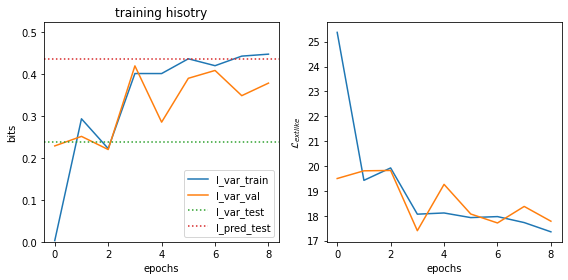

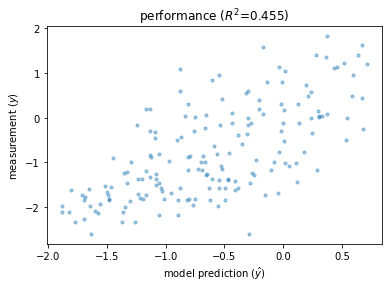

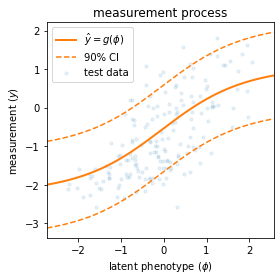

<ipython-input-2-10e8bdd99990>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0194 sec.
Epoch 1/1000
35/35 [==============================] - 0s 5ms/step - loss: 27.4532 - I_var: -0.1701 - val_loss: 21.9740 - val_I_var: -0.0807
Epoch 2/1000
35/35 [==============================] - 0s 1ms/step - loss: 22.8582 - I_var: -0.1554 - val_loss: 22.1346 - val_I_var: -0.1183
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 22.8654 - I_var: -0.1554 - val_loss: 21.9829 - val_I_var: -0.1014
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 22.7270 - I_var: -0.1283 - val_loss: 21.0073 - val_I_var: 0.0518
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 20.2570 - I_var: 0.2168 - val_loss: 18.4887 - val_I_var: 0.3552
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 19.5658 - I_var: 0.2704 - val_loss: 18.2961 - val_I_var: 0.3887
Epoch 7/1000
35/35 [=============================

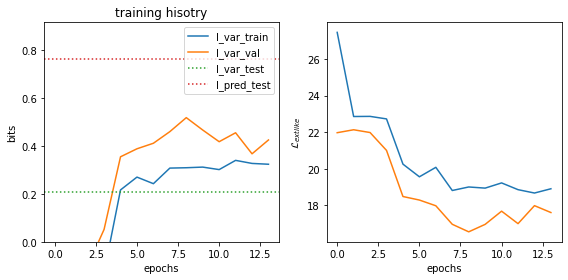

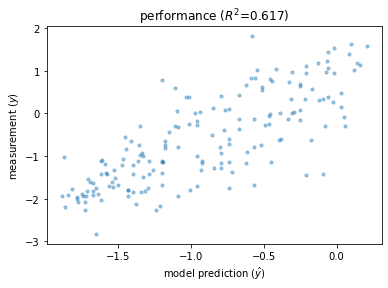

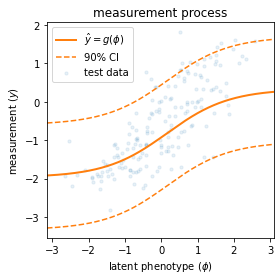

<ipython-input-2-10e8bdd99990>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0172 sec.
Epoch 1/1000
18/18 [==============================] - 0s 9ms/step - loss: 46.8847 - I_var: 0.0376 - val_loss: 32.6580 - val_I_var: 0.4608
Epoch 2/1000
18/18 [==============================] - 0s 2ms/step - loss: 36.4264 - I_var: 0.3151 - val_loss: 37.8591 - val_I_var: 0.1226
Epoch 3/1000
18/18 [==============================] - 0s 2ms/step - loss: 36.1702 - I_var: 0.3186 - val_loss: 31.5179 - val_I_var: 0.4803
Epoch 4/1000
18/18 [==============================] - 0s 2ms/step - loss: 34.9485 - I_var: 0.3249 - val_loss: 31.0479 - val_I_var: 0.4697
Epoch 5/1000
18/18 [==============================] - 0s 2ms/step - loss: 33.5725 - I_var: 0.3954 - val_loss: 32.3756 - val_I_var: 0.4419
Epoch 6/1000
18/18 [==============================] - 0s 2ms/step - loss: 34.7199 - I_var: 0.3623 - val_loss: 32.9054 - val_I_var: 0.4246
Epoch 7/1000
18/18 [==============================] - 0s

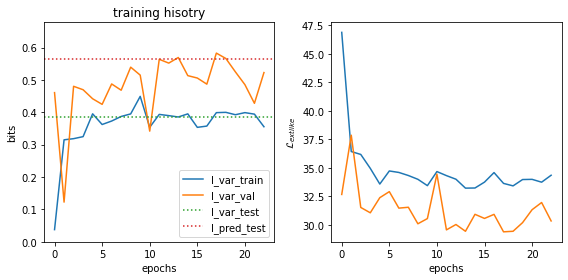

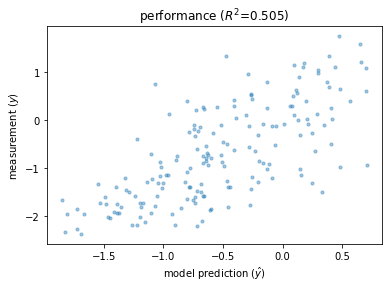

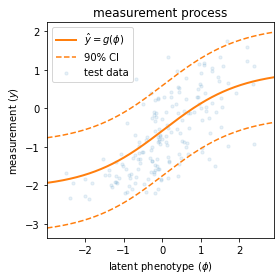

<ipython-input-2-10e8bdd99990>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0199 sec.
Epoch 1/1000
18/18 [==============================] - 0s 9ms/step - loss: 51.2677 - I_var: -0.0838 - val_loss: 36.5920 - val_I_var: 0.2520
Epoch 2/1000
18/18 [==============================] - 0s 2ms/step - loss: 36.4551 - I_var: 0.3233 - val_loss: 34.4631 - val_I_var: 0.3040
Epoch 3/1000
18/18 [==============================] - 0s 2ms/step - loss: 36.1563 - I_var: 0.3425 - val_loss: 32.2742 - val_I_var: 0.4135
Epoch 4/1000
18/18 [==============================] - 0s 2ms/step - loss: 35.6108 - I_var: 0.3524 - val_loss: 32.9596 - val_I_var: 0.4570
Epoch 5/1000
18/18 [==============================] - 0s 2ms/step - loss: 34.4687 - I_var: 0.3807 - val_loss: 33.4325 - val_I_var: 0.4416
Epoch 6/1000
18/18 [==============================] - 0s 2ms/step - loss: 35.7519 - I_var: 0.3468 - val_loss: 33.9086 - val_I_var: 0.3165
Epoch 7/1000
18/18 [==============================] - 0

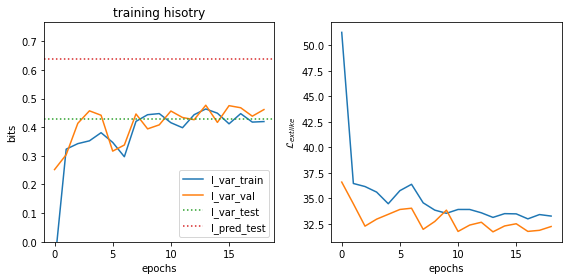

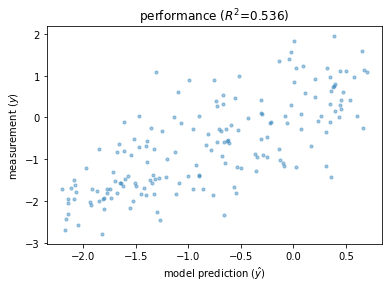

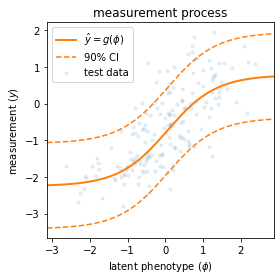

<ipython-input-2-10e8bdd99990>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0178 sec.
Epoch 1/1000
12/12 [==============================] - 0s 14ms/step - loss: 80.1279 - I_var: -0.2164 - val_loss: 68.3192 - val_I_var: -0.1679
Epoch 2/1000
12/12 [==============================] - 0s 2ms/step - loss: 68.2077 - I_var: -0.1849 - val_loss: 66.0659 - val_I_var: -0.1732
Epoch 3/1000
12/12 [==============================] - 0s 2ms/step - loss: 67.3542 - I_var: -0.1813 - val_loss: 65.7882 - val_I_var: -0.1738
Epoch 4/1000
12/12 [==============================] - 0s 2ms/step - loss: 66.8864 - I_var: -0.1725 - val_loss: 65.4329 - val_I_var: -0.1688
Epoch 5/1000
12/12 [==============================] - 0s 2ms/step - loss: 66.6852 - I_var: -0.1698 - val_loss: 65.4247 - val_I_var: -0.1687
Epoch 6/1000
12/12 [==============================] - 0s 2ms/step - loss: 66.8775 - I_var: -0.1616 - val_loss: 65.4633 - val_I_var: -0.1708
Epoch 7/1000
12/12 [=======================

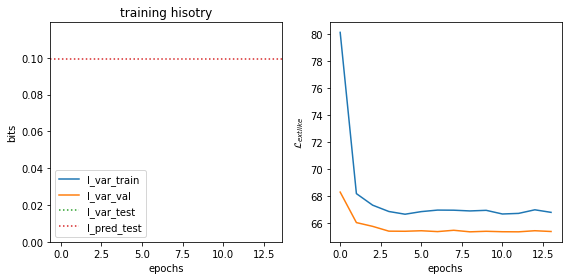

/Users/yiquan/opt/anaconda3/envs/NA/lib/python3.8/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yiquan/opt/anaconda3/envs/NA/lib/python3.8/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


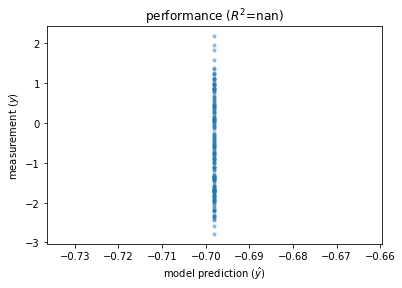

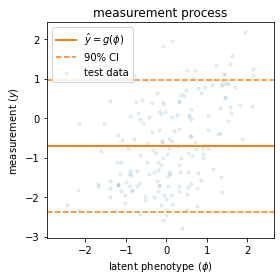

<ipython-input-2-10e8bdd99990>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0204 sec.
Epoch 1/1000
12/12 [==============================] - 0s 14ms/step - loss: 77.5737 - I_var: -0.1873 - val_loss: 68.9563 - val_I_var: -0.1814
Epoch 2/1000
12/12 [==============================] - 0s 2ms/step - loss: 67.3420 - I_var: -0.1157 - val_loss: 63.3669 - val_I_var: -0.0592
Epoch 3/1000
12/12 [==============================] - 0s 2ms/step - loss: 57.7462 - I_var: 0.1697 - val_loss: 53.4596 - val_I_var: 0.2731
Epoch 4/1000
12/12 [==============================] - 0s 2ms/step - loss: 54.4982 - I_var: 0.2852 - val_loss: 53.6454 - val_I_var: 0.2865
Epoch 5/1000
12/12 [==============================] - 0s 2ms/step - loss: 52.6439 - I_var: 0.3367 - val_loss: 50.8178 - val_I_var: 0.3790
Epoch 6/1000
12/12 [==============================] - 0s 2ms/step - loss: 49.6381 - I_var: 0.4191 - val_loss: 49.3802 - val_I_var: 0.4125
Epoch 7/1000
12/12 [==============================]

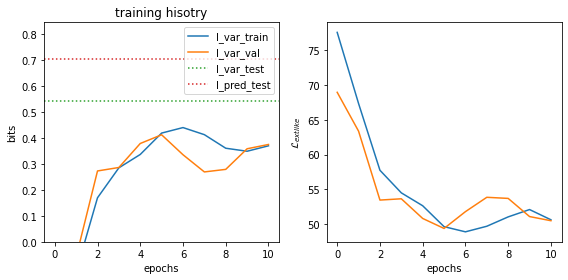

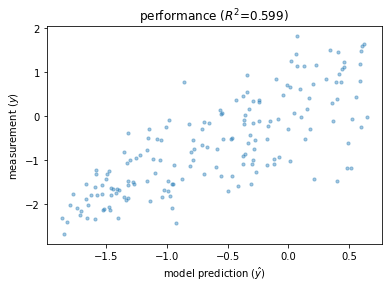

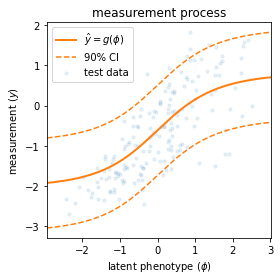

<ipython-input-2-10e8bdd99990>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0197 sec.
Epoch 1/1000
9/9 [==============================] - 0s 20ms/step - loss: 100.8034 - I_var: -0.0735 - val_loss: 81.5831 - val_I_var: 0.1219
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 72.8644 - I_var: 0.3497 - val_loss: 70.5085 - val_I_var: 0.2716
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 67.1063 - I_var: 0.4645 - val_loss: 71.4158 - val_I_var: 0.2754
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 65.6690 - I_var: 0.5021 - val_loss: 69.3607 - val_I_var: 0.2678
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 65.3889 - I_var: 0.4899 - val_loss: 72.5465 - val_I_var: 0.1950
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 65.7782 - I_var: 0.5001 - val_loss: 83.5959 - val_I_var: 0.0164
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step -

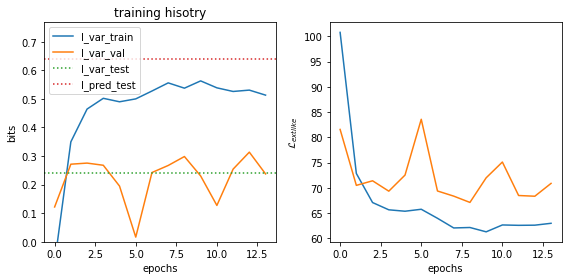

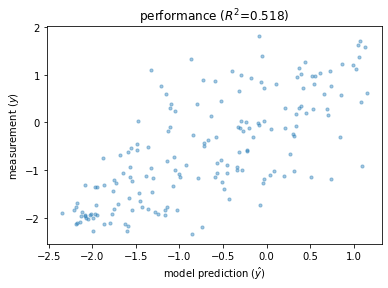

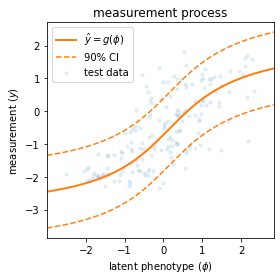

<ipython-input-2-10e8bdd99990>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.019 sec.
Epoch 1/1000
9/9 [==============================] - 0s 24ms/step - loss: 94.7863 - I_var: -0.0280 - val_loss: 74.4852 - val_I_var: 0.1420
Epoch 2/1000
9/9 [==============================] - 0s 3ms/step - loss: 70.5638 - I_var: 0.3343 - val_loss: 61.8911 - val_I_var: 0.4274
Epoch 3/1000
9/9 [==============================] - 0s 3ms/step - loss: 68.7141 - I_var: 0.3676 - val_loss: 64.4255 - val_I_var: 0.2512
Epoch 4/1000
9/9 [==============================] - 0s 3ms/step - loss: 67.9022 - I_var: 0.3685 - val_loss: 64.1151 - val_I_var: 0.3164
Epoch 5/1000
9/9 [==============================] - 0s 3ms/step - loss: 66.9498 - I_var: 0.3817 - val_loss: 63.3580 - val_I_var: 0.3621
Epoch 6/1000
9/9 [==============================] - 0s 3ms/step - loss: 67.0908 - I_var: 0.3820 - val_loss: 59.1610 - val_I_var: 0.5015
Epoch 7/1000
9/9 [==============================] - 0s 3ms/step - l

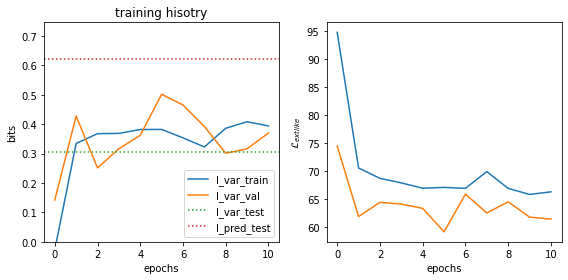

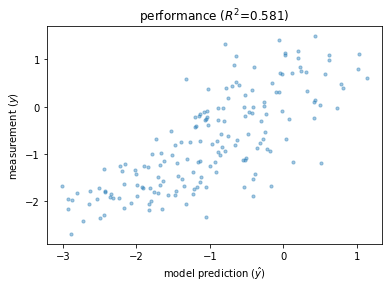

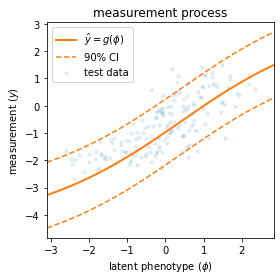

<ipython-input-2-10e8bdd99990>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0184 sec.
Epoch 1/1000
5/5 [==============================] - 0s 30ms/step - loss: 192.2158 - I_var: -0.1159 - val_loss: 194.1915 - val_I_var: -0.0287
Epoch 2/1000
5/5 [==============================] - 0s 4ms/step - loss: 178.9938 - I_var: -0.0729 - val_loss: 179.5154 - val_I_var: 0.0744
Epoch 3/1000
5/5 [==============================] - 0s 5ms/step - loss: 161.5836 - I_var: 0.0918 - val_loss: 150.4157 - val_I_var: 0.3150
Epoch 4/1000
5/5 [==============================] - 0s 4ms/step - loss: 139.5565 - I_var: 0.3130 - val_loss: 132.2881 - val_I_var: 0.5845
Epoch 5/1000
5/5 [==============================] - 0s 5ms/step - loss: 128.9674 - I_var: 0.4252 - val_loss: 125.5506 - val_I_var: 0.7064
Epoch 6/1000
5/5 [==============================] - 0s 4ms/step - loss: 130.9621 - I_var: 0.4194 - val_loss: 124.1295 - val_I_var: 0.7399
Epoch 7/1000
5/5 [==============================] - 

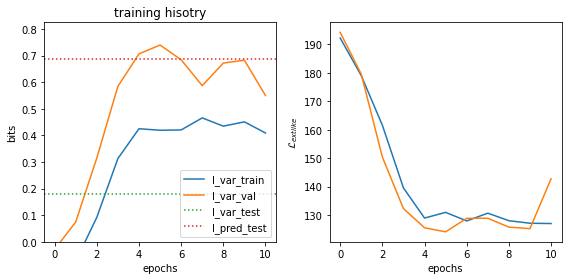

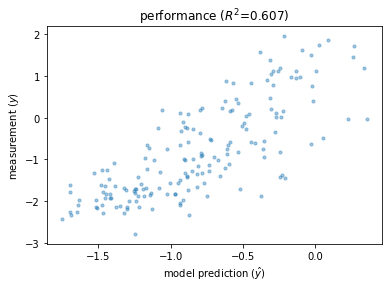

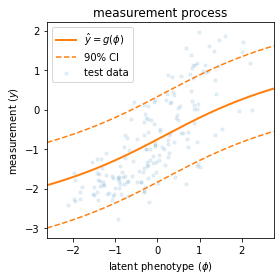

<ipython-input-2-10e8bdd99990>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


N = 691 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 0.0217 sec.
Epoch 1/1000
5/5 [==============================] - 0s 85ms/step - loss: 189.3319 - I_var: -0.0840 - val_loss: 171.1131 - val_I_var: 0.1023
Epoch 2/1000
5/5 [==============================] - 0s 4ms/step - loss: 167.2167 - I_var: 0.0507 - val_loss: 147.9011 - val_I_var: 0.2547
Epoch 3/1000
5/5 [==============================] - 0s 4ms/step - loss: 147.0515 - I_var: 0.2622 - val_loss: 132.5867 - val_I_var: 0.4274
Epoch 4/1000
5/5 [==============================] - 0s 5ms/step - loss: 140.6411 - I_var: 0.3300 - val_loss: 122.7314 - val_I_var: 0.5746
Epoch 5/1000
5/5 [==============================] - 0s 5ms/step - loss: 133.7820 - I_var: 0.3737 - val_loss: 116.4191 - val_I_var: 0.6488
Epoch 6/1000
5/5 [==============================] - 0s 5ms/step - loss: 127.8440 - I_var: 0.4183 - val_loss: 116.4887 - val_I_var: 0.6554
Epoch 7/1000
5/5 [==============================] - 0s

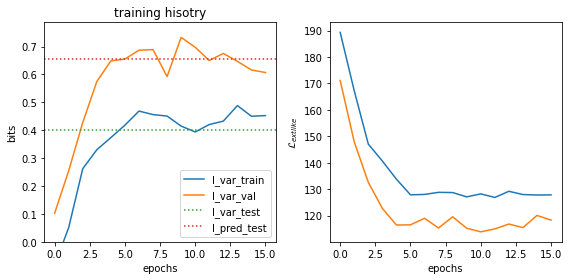

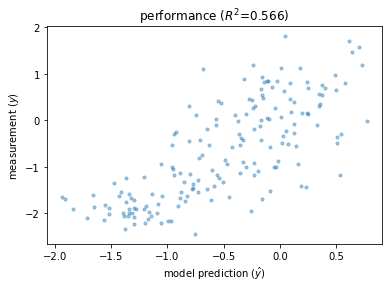

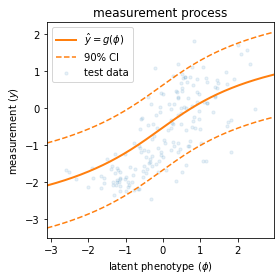

[[0.9104936 ]
 [0.9793811 ]
 [0.52975285]
 [0.97216624]
 [0.84149768]]


In [8]:
#Find the best regularization for additive fitness(batch_size)
bs_ls=[16,32,48,64,128]
add=np.zeros((5,1))
epi=np.zeros((5,1))
R2=np.zeros((19,2))
R2_epi=np.zeros((153,2))
for bs in bs_ls:
    for rep in [0,1]:
        train_set, test_set = LoadData('../result/NA_compile_results.tsv','HK19')
        model = Train_model(train_set,test_set,0.8,0.05,bs)
        PlotTrain(model,test_set)
        PlotR2(model,test_set)
        PlotGEnonlinearity(model,test_set)
        theta = model.get_theta()
#         fig, ax = plt.subplots(1, 1, figsize=[16, 10])
#         mavenn.heatmap_pairwise(values=theta['theta_lclc'],alphabet=theta['alphabet'], ax=ax);
        theta_lc=theta['theta_lc']
#         data = theta['theta_lclc']
#         epi_map=array2df(data)
#         epi_map=epi_map.dropna(thresh=3)
#         epi_df = df2epimap(epi_map)

        add_df=reformat(theta_lc)
        R2[:,rep]=add_df['add_fit']
#         R2_epi[:,rep]=epi_df['EPI']
    R = np.corrcoef(R2[:,0], R2[:,1])[0, 1]
#     R_epi = np.corrcoef(R2_epi[:,0], R2_epi[:,1])[0, 1]
    index = bs_ls.index(bs)
    add[index,0]=R
#     epi[index,0]=R_epi
print(add)
# print(epi)

We now define a MAVE-NN model with pairwise G-P map and a Gaussian noise model.

<ipython-input-2-10e8bdd99990>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


     index       ID strain        pI  charge  rep1_fit  rep2_fit       fit  \
0       91  KDKGKDL   HK68  6.374817       1  0.004584  0.008018  0.006301   
1      322  KDESEKL   HK68  6.088928      -1  0.041413  0.115327  0.078370   
2      256  KDESEEL   HK68  5.850403      -3  0.001614  0.047281  0.024448   
3      553  NNESEES   HK68  5.848694      -3  0.019460  0.126476  0.072968   
4      328  NNKSKTL   HK68  6.553528       2  0.008740  0.041962  0.025351   
..     ...      ...    ...       ...     ...       ...       ...       ...   
686    752  KDKNETL   HK68  6.222717       0  0.172512  0.038294  0.105403   
687    153  NSKSKKL   HK68  6.776550       3  0.027818  0.001484  0.014651   
688    306  KDKSETL   HK68  6.222717       0  0.141418  0.318114  0.229766   
689     42  NSRNKTL   HK68  6.553528       2  0.020175  0.018163  0.019169   
690    602  NSKSEEL   HK68  6.087708      -1  0.030977  0.198761  0.114869   

            y    set  
0   -5.066989  train  
1   -2.546308  tr

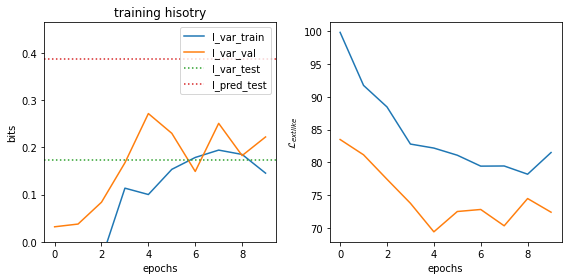

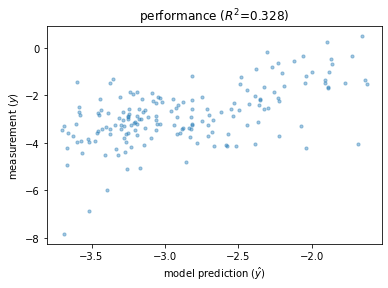

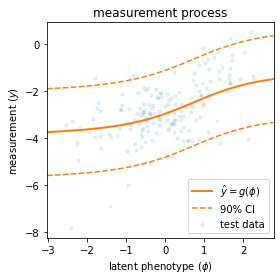

    pos aa   add_fit
0   328  K -0.346225
1   328  N  0.238933
2   329  D  0.392255
3   329  N -0.358075
4   329  S -0.207617
5   344  E -0.297458
6   344  K  0.143036
7   344  R  0.107421
8   367  G -0.412165
9   367  N  0.153686
10  367  S  0.235609
11  368  E  0.406663
12  368  K -0.414900
13  369  D  0.398208
14  369  E -0.023931
15  369  K -0.468622
16  369  T -0.002261
17  370  L -0.272437
18  370  S  0.088254


In [5]:
##Loading HK68 data, training and plotting
train_set, test_set = LoadData('../result/NA_compile_results.tsv','HK68')
print(train_set)
model = Train_model(train_set,test_set,0.5,0.05,64)
PlotTrain(model,test_set)
PlotR2(model,test_set)
PlotGEnonlinearity(model,test_set)
# Save model
#model.save('../result/HK68_epi')
#model = mavenn.load('../result/HK68_epi')
## Plot additive
## Plot epistasis
theta = model.get_theta()
# fig, ax = plt.subplots(1, 1, figsize=[16, 10])
# mavenn.heatmap_pairwise(values=theta['theta_lclc'],alphabet=theta['alphabet'], ax=ax);
#save epistasis and additive
# data = theta['theta_lclc']
theta_lc=theta['theta_lc']
# epi_map=array2df(data)
# epi_map=epi_map.dropna(thresh=3)
# epi_df = df2epimap(epi_map)
# epi_df.to_csv('../result/HK68_epi.csv')
# print(epi_df)
add_df=reformat(theta_lc)
add_df.to_csv('../result/add_model/HK68_add.csv')
print(add_df)

<ipython-input-2-10e8bdd99990>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


     index       ID strain        pI  charge  rep1_fit  rep2_fit       fit  \
0      952  NSENETS   Bk79  6.512268      -2  0.108506  1.944050  1.026278   
1     1450  NNKNEKL   Bk79  7.404846       1  0.163371  0.422291  0.292831   
2      903  NDEGKKL   Bk79  7.040100       0  0.583578  0.245344  0.414461   
3     1250  NSRNKEL   Bk79  7.405701       1  0.227027  0.111122  0.169075   
4     1377  NDKGKKL   Bk79  7.728455       2  0.116743  0.100375  0.108559   
..     ...      ...    ...       ...     ...       ...       ...       ...   
686   1599  NSKSEKS   Bk79  7.404846       1  0.697069  1.302738  0.999903   
687   1001  KDRGEEL   Bk79  6.742249      -1  0.143445  0.814851  0.479148   
688    895  NNKGKKS   Bk79  7.959900       3  0.140679  0.155172  0.147926   
689   1041  NSRGEEL   Bk79  6.741882      -1  0.180203  0.696735  0.438469   
690   1593  KDENEEL   Bk79  6.330017      -3  0.439781  0.938943  0.689362   

            y    set  
0    0.025939  train  
1   -1.228159  tr

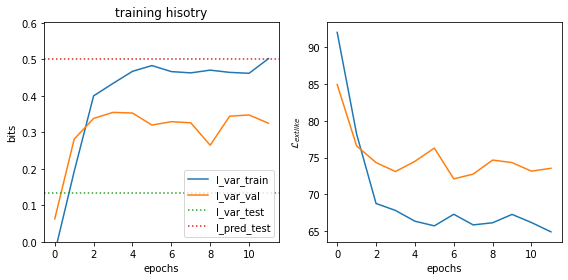

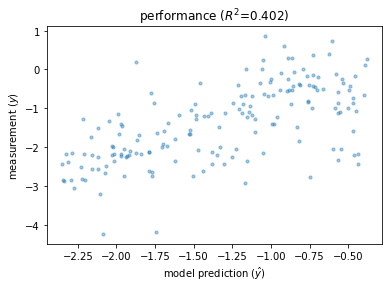

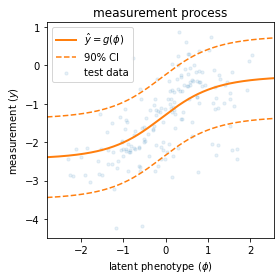

    pos aa   add_fit
0   328  K -0.424024
1   328  N  0.045327
2   329  D  0.694435
3   329  N -0.577215
4   329  S -0.444542
5   344  E  0.160952
6   344  K -0.386495
7   344  R -0.002278
8   367  G -0.717286
9   367  N  0.587832
10  367  S  0.489708
11  368  E  0.975279
12  368  K -0.840874
13  369  D  0.907094
14  369  E  0.196347
15  369  K -0.556217
16  369  T -0.379406
17  370  L  0.012608
18  370  S -0.001719


In [22]:
##Loading Bk79 data, training and plotting
train_set, test_set = LoadData('../result/NA_compile_results.tsv','Bk79')
print(train_set)
model = Train_model(train_set,test_set,0.1,0.05,64)
PlotTrain(model,test_set)
PlotR2(model,test_set)
PlotGEnonlinearity(model,test_set)
# Save model
# model.save('../result/Bk79_epi')
#model = mavenn.load('../result/Bk79_epi')

## Plot epistasis
theta = model.get_theta()
# fig, ax = plt.subplots(1, 1, figsize=[16, 10])
# mavenn.heatmap_pairwise(values=theta['theta_lclc'],alphabet=theta['alphabet'], ax=ax);
#save epistasis and additive
# data = theta['theta_lclc']
theta_lc=theta['theta_lc']
# epi_map=array2df(data)
# epi_map=epi_map.dropna(thresh=3)
# epi_df = df2epimap(epi_map)
# epi_df.to_csv('../result/Bk79_epi.csv')
# print(epi_df)
add_df=reformat(theta_lc)
add_df.to_csv('../result/add_model/Bk79_add.csv')
print(add_df)

<ipython-input-2-10e8bdd99990>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


     index       ID strain        pI  charge  rep1_fit   rep2_fit       fit  \
0     2118  KSRSEKL  Bei89  7.734802       2  0.125676   0.115127  0.120402   
1     2438  KSRNKKL  Bei89  8.129333       4  0.205301   0.081336  0.143318   
2     1788  KDKGEES  Bei89  6.778381      -1  1.106075   1.092152  1.099114   
3     2575  NDENKDL  Bei89  6.555603      -2  2.241531  10.492926  6.367229   
4     2514  KDKGKEL  Bei89  7.416931       1  0.272645   0.180540  0.226593   
..     ...      ...    ...       ...     ...       ...        ...       ...   
686   1911  NNKGKEL  Bei89  7.417786       1  0.307956   0.352394  0.330175   
687   1879  KNRGEDS  Bei89  7.066467       0  0.728351   0.497756  0.613054   
688   1794  NDRGETL  Bei89  6.777527      -1  0.183886   0.185296  0.184591   
689   1943  KNKSKKS  Bei89  8.127380       4  0.293789   0.153941  0.223865   
690   2550  NDRGKKL  Bei89  7.734680       2  0.093249   0.058410  0.075830   

            y    set  
0   -2.116921    val  
1   -

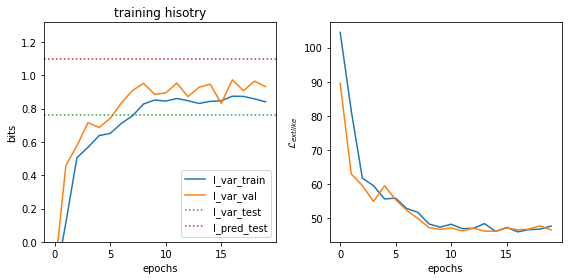

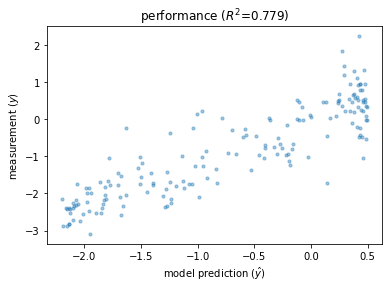

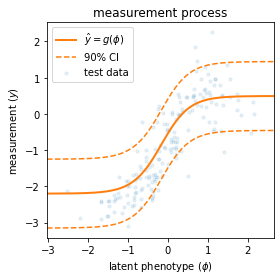

    pos aa   add_fit
0   328  K -0.002870
1   328  N  0.183733
2   329  D  0.198346
3   329  N -0.014251
4   329  S -0.167722
5   344  E  0.496753
6   344  K -0.122445
7   344  R -0.269605
8   367  G -0.358980
9   367  N  0.304463
10  367  S  0.132875
11  368  E  0.614177
12  368  K -0.608481
13  369  D  0.587380
14  369  E  0.325755
15  369  K -0.770330
16  369  T  0.049284
17  370  L -0.163666
18  370  S -0.183004


In [21]:
##Loading Bei89 data, training and plotting
train_set, test_set = LoadData('../result/NA_compile_results.tsv','Bei89')
print(train_set)
model = Train_model(train_set,test_set,0.8,0.05,64)
PlotTrain(model,test_set)
PlotR2(model,test_set)
PlotGEnonlinearity(model,test_set)
# Save model
# model.save('../result/Bei89_epi')
#model = mavenn.load('../result/Bei89_epi')

## Plot epistasis
theta = model.get_theta()
# fig, ax = plt.subplots(1, 1, figsize=[16, 10])
# mavenn.heatmap_pairwise(values=theta['theta_lclc'],alphabet=theta['alphabet'], ax=ax);
# #save epistasis and additive
# data = theta['theta_lclc']
theta_lc=theta['theta_lc']
# epi_map=array2df(data)
# epi_map=epi_map.dropna(thresh=3)
# epi_df = df2epimap(epi_map)
# epi_df.to_csv('../result/Bei89_epi.csv')
# print(epi_df)
add_df=reformat(theta_lc)
add_df.to_csv('../result/add_model/Bei89_add.csv')
print(add_df)

<ipython-input-2-10e8bdd99990>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


     index       ID strain        pI  charge  rep1_fit  rep2_fit       fit  \
0     2778  KSRNEKL  Mos99  6.556458       2  0.359846  0.317200  0.338523   
1     3331  NDEGEDS  Mos99  5.742981      -4  0.207194  0.194138  0.200666   
2     3237  KNRGKDS  Mos99  6.555603       2  0.134866  0.245842  0.190354   
3     2634  NSRNKTL  Mos99  6.554993       2  0.293233  0.320125  0.306679   
4     2993  KSEGEES  Mos99  5.969910      -2  0.666667  0.769440  0.718053   
..     ...      ...    ...       ...     ...       ...       ...       ...   
686   2988  NSRSEKL  Mos99  6.377380       1  0.239437  0.506764  0.373100   
687   2696  KNENEDS  Mos99  5.967834      -2  0.555450  0.539988  0.547719   
688   3226  NDEGKDS  Mos99  5.965637      -2  0.503158  0.574421  0.538790   
689   3441  KDENKTL  Mos99  6.225403       0  0.788506  0.932246  0.860376   
690   3257  NSRNETL  Mos99  6.224548       0  0.703077  1.999671  1.351374   

            y    set  
0   -1.083164  train  
1   -1.606113  tr

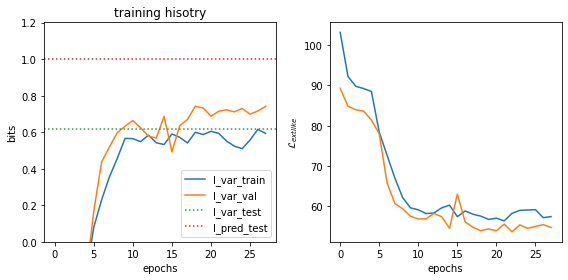

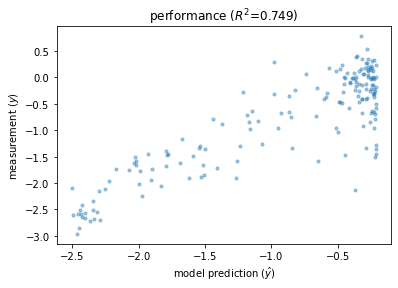

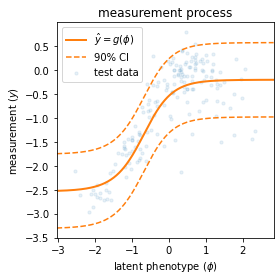

    pos aa   add_fit
0   328  K -0.110608
1   328  N  0.233313
2   329  D  0.371764
3   329  N -0.188421
4   329  S -0.078244
5   344  E  0.590524
6   344  K -0.239939
7   344  R -0.236042
8   367  G -0.176704
9   367  N  0.173810
10  367  S  0.106223
11  368  E  0.668227
12  368  K -0.578621
13  369  D  0.493126
14  369  E  0.413805
15  369  K -0.761962
16  369  T -0.019500
17  370  L  0.147285
18  370  S -0.017549


In [20]:
##Loading Mos99 data, training and plotting
train_set, test_set = LoadData('../result/NA_compile_results.tsv','Mos99')
print(train_set)
model = Train_model(train_set,test_set,0.8,0.05,64)
PlotTrain(model,test_set)
PlotR2(model,test_set)
PlotGEnonlinearity(model,test_set)
# Save model
# model.save('../result/Mos99_epi')
#model = mavenn.load('../result/Mos99_epi')

## Plot epistasis
theta = model.get_theta()
# fig, ax = plt.subplots(1, 1, figsize=[16, 10])
# mavenn.heatmap_pairwise(values=theta['theta_lclc'],alphabet=theta['alphabet'], ax=ax);
# #save epistasis and additive
# data = theta['theta_lclc']
theta_lc=theta['theta_lc']
# epi_map=array2df(data)
# epi_map=epi_map.dropna(thresh=3)
# epi_df = df2epimap(epi_map)
# epi_df.to_csv('../result/Mos99_epi.csv')
# print(epi_df)
add_df=reformat(theta_lc)
add_df.to_csv('../result/add_model/Mos99_add.csv')
print(add_df)

<ipython-input-2-10e8bdd99990>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


     index       ID strain        pI  charge  rep1_fit  rep2_fit       fit  \
0     4237  NSRGKEL  Vic11  6.780090       1  0.038388  0.156254  0.097321   
1     3757  NNKSEKL  Vic11  6.779846       1  0.530278  0.553475  0.541877   
2     3764  NNRGEKL  Vic11  6.780090       1  0.096958  0.172311  0.134635   
3     4297  KNKGEKL  Vic11  7.070374       2  0.188998  0.111555  0.150276   
4     3781  KDKNKTS  Vic11  7.069885       2  0.716274  0.593154  0.654714   
..     ...      ...    ...       ...     ...       ...       ...       ...   
686   3631  KNKSEEL  Vic11  6.558655       0  0.251751  0.610319  0.431035   
687   3779  NDKSETS  Vic11  6.378601      -1  1.839137  0.568429  1.203783   
688   4057  NNEGKKL  Vic11  6.779846       1  0.144249  0.130616  0.137433   
689   3745  NSKSKTL  Vic11  7.070007       2  0.123587  0.177061  0.150324   
690   4233  NSRGKTL  Vic11  7.070374       2  0.061499  0.040182  0.050841   

            y    set  
0   -2.329739    val  
1   -0.612717  tr

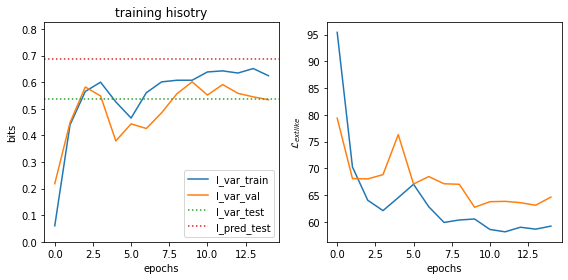

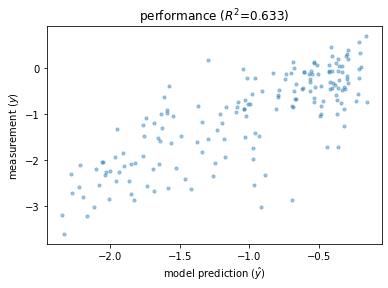

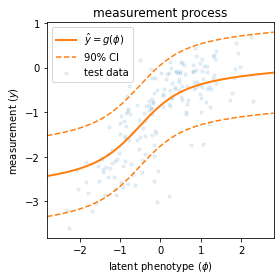

    pos aa   add_fit
0   328  K  0.068372
1   328  N  0.036043
2   329  D  0.183785
3   329  N -0.023581
4   329  S -0.033942
5   344  E  0.249684
6   344  K -0.029116
7   344  R -0.103394
8   367  G -0.449223
9   367  N  0.309489
10  367  S  0.141440
11  368  E  0.442321
12  368  K -0.560527
13  369  D  0.603851
14  369  E -0.213957
15  369  K -0.315722
16  369  T  0.017666
17  370  L -0.166688
18  370  S  0.260491


In [19]:
##Loading Vic11 data, training and plotting
train_set, test_set = LoadData('../result/NA_compile_results.tsv','Vic11')
print(train_set)
model = Train_model(train_set,test_set,0.8,0.05,64)
PlotTrain(model,test_set)
PlotR2(model,test_set)
PlotGEnonlinearity(model,test_set)
# Save model
# model.save('../result/Vic11_epi')
#model = mavenn.load('../result/Vic11_epi')

## Plot epistasis
theta = model.get_theta()
# fig, ax = plt.subplots(1, 1, figsize=[16, 10])
# mavenn.heatmap_pairwise(values=theta['theta_lclc'],alphabet=theta['alphabet'], ax=ax);
# #save epistasis and additive
# data = theta['theta_lclc']
theta_lc=theta['theta_lc']
# epi_map=array2df(data)
# epi_map=epi_map.dropna(thresh=3)
# epi_df = df2epimap(epi_map)
# epi_df.to_csv('../result/Vic11_epi.csv')
# print(epi_df)
add_df=reformat(theta_lc)
add_df.to_csv('../result/add_model/Vic11_add.csv')
print(add_df)

<ipython-input-2-10e8bdd99990>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strain['y']= np.log(df_strain['fit'])


     index       ID strain        pI  charge  rep1_fit  rep2_fit       fit  \
0     4966  NDKSEKS   HK19  6.422913       0  1.125782  2.886532  2.006157   
1     4619  NNKGKKL   HK19  7.093811       3  0.259479  0.103401  0.181440   
2     4996  KSKGKTS   HK19  7.093811       3  0.126056  0.145382  0.135719   
3     5065  KSRSKTS   HK19  7.094299       3  0.192472  0.134774  0.163623   
4     4928  KSKSKKS   HK19  7.438293       4  0.112045  0.171220  0.141632   
..     ...      ...    ...       ...     ...       ...       ...       ...   
686   4341  KSKSEDS   HK19  6.422913       0  1.729364  2.536116  2.132740   
687   4348  NNRGKTS   HK19  6.812073       2  0.212290  0.175546  0.193918   
688   4530  KNESKTL   HK19  6.596497       1  0.226123  0.227834  0.226978   
689   4645  KDKNKTS   HK19  6.812195       2  0.371580  0.253101  0.312341   
690   4882  NDESKEL   HK19  6.145935      -2  0.355510  0.271635  0.313572   

            y    set  
0    0.696221  train  
1   -1.706830    

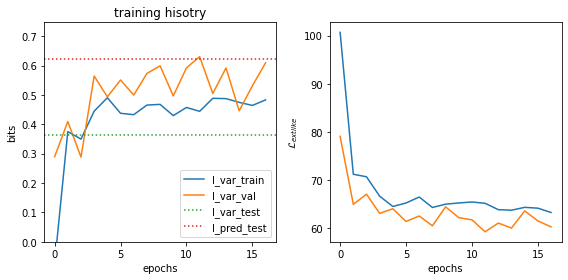

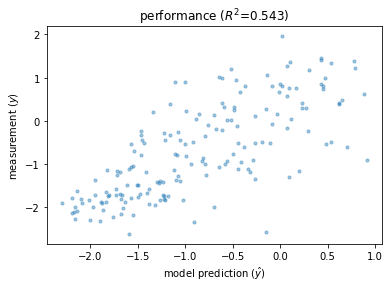

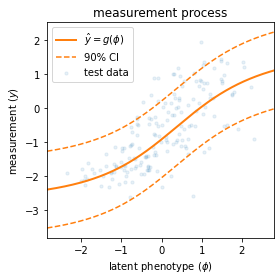

    pos aa   add_fit
0   328  K -0.097994
1   328  N -0.033525
2   329  D  0.486467
3   329  N -0.400687
4   329  S -0.071188
5   344  E  0.008850
6   344  K -0.100291
7   344  R -0.036228
8   367  G -0.559253
9   367  N  0.157346
10  367  S  0.242752
11  368  E  0.325495
12  368  K -0.512456
13  369  D  0.251945
14  369  E -0.131310
15  369  K -0.286013
16  369  T  0.082260
17  370  L -0.201263
18  370  S  0.164331


In [16]:
##Loading HK19 data, training and plotting
train_set, test_set = LoadData('../result/NA_compile_results.tsv','HK19')
print(train_set)
model = Train_model(train_set,test_set,0.8,0.05,64)
PlotTrain(model,test_set)
PlotR2(model,test_set)
PlotGEnonlinearity(model,test_set)
# Save model
# model.save('../result/HK19_epi')
#model = mavenn.load('../result/HK19_epi')

## Plot epistasis
theta = model.get_theta()
# fig, ax = plt.subplots(1, 1, figsize=[16, 10])
# mavenn.heatmap_pairwise(values=theta['theta_lclc'],alphabet=theta['alphabet'], ax=ax);
# #save epistasis and additive
# data = theta['theta_lclc']
theta_lc=theta['theta_lc']
# epi_map=array2df(data)
# epi_map=epi_map.dropna(thresh=3)
# epi_df = df2epimap(epi_map)
# epi_df.to_csv('../result/HK19_epi.csv')
# print(epi_df)
add_df=reformat(theta_lc)
add_df.to_csv('../result/add_model/HK19_add.csv')
print(add_df)